# Analysis of Single Cell Data from CSF Project
- Roy Jiang
- June 11, 2020
- Cloning. Clonal overlap. Repertoire analysis for Diversity, Isotype, SHM, (Vgene). Directionality/Size Change.

# Before running

- This notebook assumes that the processing notebook has completed and changeo files have been generated. It also assumes that you have placed the csf object in the main directory you will be mounting. 

In [ ]:
TENX_META_FILE = "/git/projects/Song2021_CellReports/meta.csv"
ASSIGNMENT_FILE = "/git/projects/Song2021_CellReports/assignments.csv"
CELLRANGER_DIR = "/data/cellranger"
CSF_OBJECT = "/data/csf.rds"

SATURN_SOURCE = "/git/pipeline_abseq/api/saturn/saturn.R"

### Generated by this notebook
OUT_TAB = "/data/out_bcr.tab"

### For outputting figures and tables
BASE_DIR = "/data"
TABLES_DIR <- "/data"

human_ref_dir <- "/usr/local/share/germlines/imgt/human/vdj"

dir.create(file.path(BASE_DIR, "figures"))

# Load libraries

In [88]:
options(warn=-1)

In [90]:
source(SATURN_SOURCE)

In [89]:
library(shazam)
library(alakazam)
library(ggforce)
library(tidyverse)
library(ggtree)
library(scales)

In [93]:
meta_df <- read.csv(TENX_META_FILE) %>%
    filter(TYPE == 'BCR')

In [94]:
meta_df

IDENTITY   SAMPLE SUBJECT STATUS LOCATION TYPE
1  CSF1_BCR   CSF1   P1      N      CSF      BCR 
2  CSF2_BCR   CSF2   P2      N      CSF      BCR 
3  CSF3_BCR   CSF3   P3      N      CSF      BCR 
4  CSF4_BCR   CSF4   P4      N      CSF      BCR 
5  CSF5_BCR   CSF5   P5      N      CSF      BCR 
6  CSFC1_BCR  CSFC1  P6      C      CSF      BCR 
7  CSFC2_BCR  CSFC2  P7      C      CSF      BCR 
8  CSFC3_BCR  CSFC3  P8      C      CSF      BCR 
9  PBMC1_BCR  PBMC1  P1      N      PBMC     BCR 
10 PBMC6_BCR  PBMC6  P1      N      PBMC     BCR 
11 PBMC7_BCR  PBMC7  P2      N      PBMC     BCR 
12 PBMC5_BCR  PBMC5  P3      N      PBMC     BCR 
13 PBMC8_BCR  PBMC8  P4      N      PBMC     BCR 
14 PBMC9_BCR  PBMC9  P5      N      PBMC     BCR 
15 PBMC10_BCR PBMC10 P6      C      PBMC     BCR 
16 PBMC11_BCR PBMC11 P7      C      PBMC     BCR 
17 PBMC12_BCR PBMC12 P8      C      PBMC     BCR 
   PATH                                        
1  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
2  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
3  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
4  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
5  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
6  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
7  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
8  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
9  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
10 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
11 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
12 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
13 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
14 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
15 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
16 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR
17 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/BCR

# Processing

In [42]:
lc_df <- meta_df %>%
    rowwise() %>%
    mutate(FILE = file.path(PATH, IDENTITY, "changeo", "filtered_contig_light_FUNCTIONAL-T.tab")) %>%
    ungroup() %>%
    select(IDENTITY, FILE) %>%
    group_by(IDENTITY) %>%
    do(read.csv(.$FILE, sep = '\t') %>% mutate_if(is.factor, as.character)) %>% ungroup() %>%
    left_join(meta_df, by="IDENTITY")

In [43]:
hc_df <- meta_df %>%
    rowwise() %>%
    mutate(FILE = file.path(PATH, IDENTITY, "changeo", "filtered_contig_heavy_FUNCTIONAL-T.tab")) %>%
    ungroup() %>%
    select(IDENTITY, FILE) %>%
    group_by(IDENTITY) %>%
    do(read.csv(.$FILE, sep = '\t') %>% mutate_if(is.factor, as.character)) %>% ungroup() %>%
    left_join(meta_df, by="IDENTITY")


In [38]:
hc_df %>% group_by(CELL) %>% summarize(COUNT = n()) %>% group_by(COUNT) %>% summarize(COUNT_COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


COUNT COUNT_COUNT
1 1     7360       
2 2      441       
3 3      117       
4 4       54       
5 5       11       
6 6        9

In [10]:
dim(hc_df)

[1] 8918   67

In [46]:
hc_df <- hc_df %>%
	group_by(CELL, IDENTITY) %>%
	filter(UMICOUNT == max(UMICOUNT)) %>%
	filter(CONSCOUNT == max(CONSCOUNT), n() == 1)

In [47]:
dim(hc_df)

[1] 8029   67

In [13]:
hc_df %>% 
    group_by(SUBJECT, LOCATION, SAMPLE) %>%
    summarize(COUNT = n())

`summarise()` regrouping output by 'SUBJECT', 'LOCATION' (override with `.groups` argument)


SUBJECT LOCATION SAMPLE COUNT
1  P1      CSF      CSF1   1298 
2  P1      PBMC     PBMC1   338 
3  P1      PBMC     PBMC6   583 
4  P2      CSF      CSF2     21 
5  P2      PBMC     PBMC7   749 
6  P3      CSF      CSF3      4 
7  P3      PBMC     PBMC5   609 
8  P4      CSF      CSF4     11 
9  P4      PBMC     PBMC8   911 
10 P5      CSF      CSF5      8 
11 P5      PBMC     PBMC9   287 
12 P6      CSF      CSFC1     7 
13 P6      PBMC     PBMC10  578 
14 P7      CSF      CSFC2    31 
15 P7      PBMC     PBMC11 1219 
16 P8      CSF      CSFC3    23 
17 P8      PBMC     PBMC12 1352

In [41]:
lc_df %>% group_by(CELL) %>% summarize(COUNT = n()) %>% group_by(COUNT) %>% summarize(COUNT_COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


COUNT COUNT_COUNT
1 1     7927       
2 2     1025       
3 3      182       
4 4       60       
5 5       15       
6 6        1

### Define clones

In [14]:
# Compute DTN (do this first)
dtn_tab <- hc_df %>%
	    mutate(v_call = as.character(v_call), j_call = as.character(j_call)) %>%
	    group_by(SUBJECT) %>%
	    do(distToNearest(., 
                    sequenceColumn = "junction", 
                    vCallColumn = "v_call", 
                    jCallColumn = "j_call",
                    model="ham", first=FALSE, normalize="len", nproc=1)) %>%
	    ungroup() %>%
	    do(distToNearest(., 
                    sequenceColumn = "junction", 
                    vCallColumn = "v_call", 
                    jCallColumn = "j_call",
                    model="ham", first=FALSE, normalize="len", cross="SUBJECT", nproc=1))

dtn_sum <- dtn_tab %>%
    group_by(SUBJECT) %>%
    do(data.frame(DENSITY = hist(.$DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'DTN')

cross_sum <- dtn_tab %>%
    group_by(SUBJECT) %>%
    do(data.frame(DENSITY = -1 * hist(.$CROSS_DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'CROSS')

Warning message:
“The `...` argument of `group_keys()` is deprecated as of dplyr 1.0.0.
Please `group_by()` first
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

In [321]:
toplot_df <- bind_rows(dtn_sum, cross_sum)

In [15]:
# Find threshold 
thresh_df <- hc_df %>%
    mutate(JUNCTION = junction, V_CALL = v_call, J_CALL = j_call) %>%
	group_by(SUBJECT) %>%
	do(runShazam(., NPROC=4, SUBSAMPLE = 500)) %>% ungroup()

common_threshold <- thresh_df %>%
    group_by(SUBJECT) %>%
    summarize(MEAN = mean(as.numeric(threshold), na.rm = TRUE)) %>% ungroup() %>%
    summarize(THRESH = mean(MEAN, na.rm=TRUE), SD = sd(MEAN, na.rm=TRUE)) %>% select(THRESH) %>% unlist()

Warning message:
“`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”`summarise()` ungrouping output (override with `.groups` argument)


In [331]:
# refx <- toplot_df %>%
#     filter(SUBJECT == "P1", TYPE == "CROSS")

# saveRDS(refx, "~/x.rds")

# refx <- readRDS("~/x.rds")

# ggplot(refx, aes(x=BINS, y=DENSITY)) +  geom_bar(stat = "identity")

# When you don't do this, for some reason P1 does not plot, specifically CROSS. Try it. Something very spooky...
# toplot_df %>% write.csv("x.csv")
# toplot_df <- read.csv("x.csv")

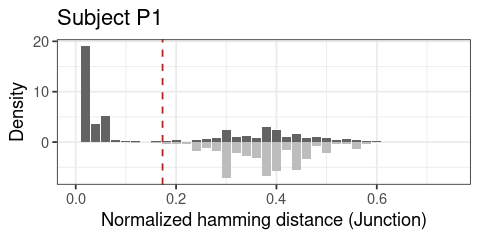

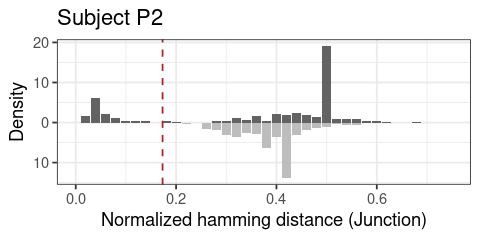

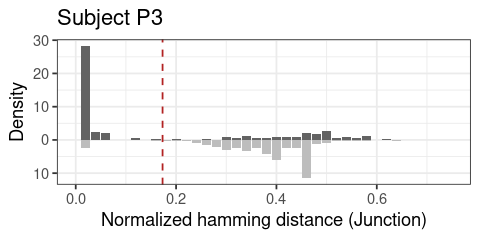

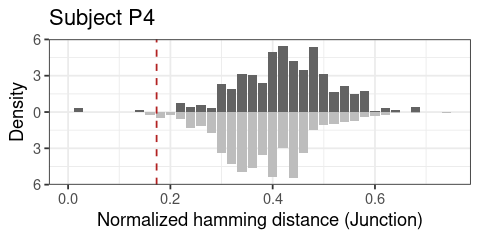

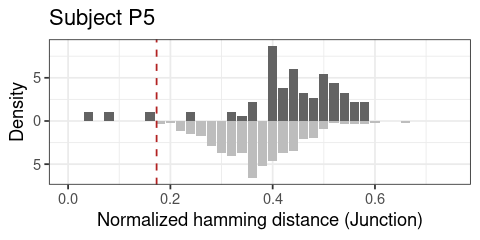

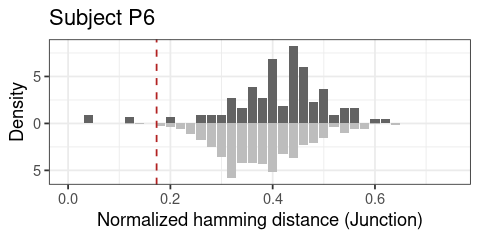

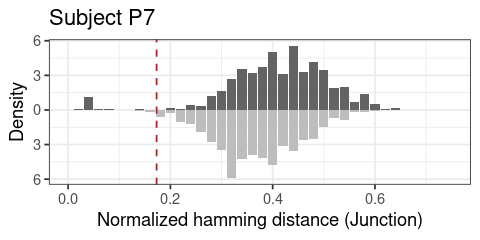

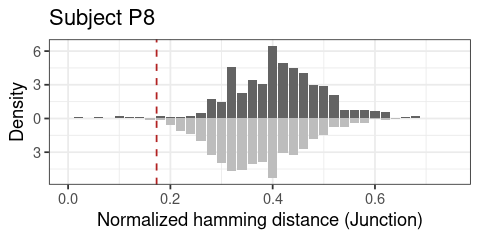

In [319]:
# Plot threshold and DTN

options(repr.plot.width = 4, repr.plot.height = 2)
DTN_COLORS <- c(
'DTN' = '#636363',
'CROSS' = '#BDBDBD'
)

for(subject in unique(toplot_df$SUBJECT)){
    
#   THRESHOLD <- thresh_df %>%
#         filter(PATIENT == patient) %>%
#         select(MEAN) %>% as.numeric()
    
#   THRESHOLD <- common_threshold
    refx <- toplot_df %>% 
        filter(SUBJECT == subject)
    
    p <- ggplot(refx, 
             aes(x=BINS, y=DENSITY, fill=TYPE)) + 
        baseTheme() + 
        theme_bw() + 
        theme(legend.position="none") +
        xlab("Normalized hamming distance (Junction)") + 
        ylab("Density") +
        ggtitle(paste("Subject", subject)) +
        geom_bar(stat = "identity") +
        geom_vline(xintercept=common_threshold, color="firebrick", linetype=2) +
        scale_x_continuous(limits=c(0,0.75)) +
        scale_y_continuous(labels=abs) +
        scale_color_manual(values=DTN_COLORS) +
        scale_fill_manual(values=DTN_COLORS)
        #facet_grid(. ~ SUBJECT) +
        #facet_wrap(~ Sample, ncol=4, scales = "free_y")
    plot(p)
    
}

In [66]:
common_threshold = 0.173055287768091

In [70]:
# Single cell cloning, createGermlines, Mutations
hc_df <- hc_df %>% 
    bind_rows(lc_df) %>%
    group_by(SUBJECT) %>%
    do(singleCellClone(., format="changeo", clone_threshold = common_threshold) %>% mutate_if(is.factor, as.character)) %>%
    runCreateGermlines(ref_dir = human_ref_dir, format = "changeo", v_call="V_CALL", sequence="SEQUENCE_IMGT") %>% 
    observedMutations(sequenceColumn = "SEQUENCE_IMGT",
                      germlineColumn = "GERMLINE_IMGT_D_MASK", 
                      frequency=TRUE)

In [17]:
hc_df <- hc_df %>% mutate(MU_FREQ = mu_freq_seq_r+mu_freq_seq_s)

In [18]:
hc_df <- hc_df %>%
    rowwise() %>%
    mutate(SUBJECT_LOCATION = paste(SUBJECT, LOCATION, sep = ','))

In [19]:
hc_df %>% 
    group_by(SUBJECT, LOCATION,SAMPLE) %>%
    summarize(COUNT = n())

`summarise()` regrouping output by 'SUBJECT', 'LOCATION' (override with `.groups` argument)


SUBJECT LOCATION SAMPLE COUNT
1  P1      CSF      CSF1   1290 
2  P1      PBMC     PBMC1   335 
3  P1      PBMC     PBMC6   574 
4  P2      CSF      CSF2     16 
5  P2      PBMC     PBMC7   717 
6  P3      CSF      CSF3      3 
7  P3      PBMC     PBMC5   594 
8  P4      CSF      CSF4     10 
9  P4      PBMC     PBMC8   880 
10 P5      CSF      CSF5      8 
11 P5      PBMC     PBMC9   282 
12 P6      CSF      CSFC1     6 
13 P6      PBMC     PBMC10  563 
14 P7      CSF      CSFC2    27 
15 P7      PBMC     PBMC11 1157 
16 P8      CSF      CSFC3    19 
17 P8      PBMC     PBMC12 1272

In [20]:
hc_df <- hc_df %>%
    group_by(CLONE, SUBJECT) %>%
    mutate(SPAN = if(length(unique(LOCATION)) == 2){"Mobile"}else{"Resident"}) %>% ungroup()

In [21]:
hc_df %>%
    group_by(SPAN, SUBJECT) %>%
    summarize(COUNT = n())

`summarise()` regrouping output by 'SPAN' (override with `.groups` argument)


SPAN     SUBJECT COUNT
1  Mobile   P1       984 
2  Mobile   P3        48 
3  Mobile   P6         2 
4  Mobile   P7        14 
5  Resident P1      1215 
6  Resident P2       733 
7  Resident P3       549 
8  Resident P4       890 
9  Resident P5       290 
10 Resident P6       567 
11 Resident P7      1170 
12 Resident P8      1291

### Assign Clusters

In [22]:
assignment_df <- read.csv(ASSIGNMENT_FILE) %>%
    select(-DESCRIPTION) %>%
    mutate(CLUSTER = as.character(CLUSTER))

obj <- readRDS(CSF_OBJECT)

In [24]:
identity_df <- data.frame(CLUSTER = obj@active.ident) %>%
    tibble::rownames_to_column("CELL") %>%
    rowwise() %>%
    mutate(CELL = paste0(strsplit(CELL, split = "_")[[1]][1], "-1")) %>%
    mutate(CLUSTER = strsplit(as.character(CLUSTER), split = '_')[[1]][1]) %>%
    ungroup() %>%
    mutate(SAMPLE=obj@meta.data$orig.ident) %>%
    mutate(SAMPLE=gsub("_", "", SAMPLE)) %>%
    left_join(assignment_df)

Joining, by = "CLUSTER"


In [25]:
identity_df %>%
    left_join(hc_df %>%
        select(CELL, SAMPLE, C_CALL) %>% mutate(VDJ = TRUE)) %>%
    filter(SUBSET == "B cell") %>%
    group_by(SAMPLE, VDJ) %>%
    summarize(COUNT = n()) %>%
    group_by(SAMPLE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(VDJ)

Joining, by = c("CELL", "SAMPLE")
`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)


SAMPLE VDJ  COUNT FREQ      
1  CSF1   TRUE 800   0.91324201
2  CSF2   TRUE   4   0.66666667
3  CSF3   TRUE   2   0.33333333
4  CSF4   TRUE   7   1.00000000
5  CSF5   TRUE   8   0.80000000
6  CSFC1  TRUE   6   0.06060606
7  CSFC2  TRUE  26   0.78787879
8  CSFC3  TRUE  13   0.68421053
9  PBMC1  TRUE 209   0.70847458
10 PBMC10 TRUE 453   0.95569620
11 PBMC11 TRUE 976   0.86219081
12 PBMC12 TRUE 994   0.90445860
13 PBMC5  TRUE 450   0.90361446
14 PBMC6  TRUE 112   0.78321678
15 PBMC7  TRUE 272   0.94444444
16 PBMC8  TRUE 621   0.91592920
17 PBMC9  TRUE 215   0.87398374

In [29]:
identity_df %>%
    left_join(hc_df %>%
        select(CELL, SAMPLE, C_CALL) %>% mutate(VDJ = TRUE)) %>%
    filter(!grepl("PBMC", SAMPLE)) %>%
    group_by(SAMPLE, VDJ) %>%
    summarize(COUNT = n()) %>%
    group_by(SAMPLE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(VDJ == TRUE) %>%
    select(SAMPLE, FREQ) %>%
    left_join(
        meta_df %>% select(SAMPLE, STATUS) %>% distinct()
    ) #%>% write.csv(file.path(BASE_DIR, "figures/partner_tables/bcr.csv"))

Joining, by = c("CELL", "SAMPLE")
`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)
Joining, by = "SAMPLE"


SAMPLE FREQ         STATUS
1 CSF1   0.2821555669 N     
2 CSF2   0.0151515152 N     
3 CSF3   0.0112359551 N     
4 CSF4   0.0022838499 N     
5 CSF5   0.0169491525 N     
6 CSFC1  0.0008362369 C     
7 CSFC2  0.0064724919 C     
8 CSFC3  0.0036307054 C

Joining, by = c("CELL", "SAMPLE")
`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)
Joining, by = "SAMPLE"


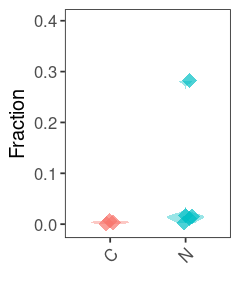

In [31]:
options(repr.plot.width=2, repr.plot.height=2.5)
p <- identity_df %>%
    left_join(hc_df %>%
        select(CELL, SAMPLE, C_CALL) %>% mutate(VDJ = TRUE)) %>%
    filter(!grepl("PBMC", SAMPLE)) %>%
    group_by(SAMPLE, VDJ) %>%
    summarize(COUNT = n()) %>%
    group_by(SAMPLE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(VDJ == TRUE) %>%
    select(SAMPLE, FREQ) %>%
    left_join(
        meta_df %>% select(SAMPLE, STATUS) %>% distinct()
    ) %>% ggplot(aes(x=STATUS, y=FREQ)) + 
    baseTheme() + 
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Fraction")) +im=T, adjust=2, width=0.5) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7)
plot(p)

In [21]:
plotFigure(p, file.path(BASE_DIR, "figures", "bcr.pdf"), 2, 2.5)

png 
  2

In [32]:
# detect multiplets
hc_df <- bind_rows(hc_df, lc_df) %>%
    group_by(CELL, SAMPLE) %>%
    mutate(NO_MULTIPLET = (paste(sort(LOCUS), collapse = ",") == "IGH,IGK") |
        (paste(sort(LOCUS), collapse = ",") == "IGH,IGL") 
    ) %>% filter(LOCUS == 'IGH')

### Read/write

In [33]:
hc_df %>% 
    write.table(file.path(BASE_DIR, "combined.tab"), sep="\t")

In [95]:
hc_df <- read.csv(file.path(BASE_DIR, "combined.tab"), sep="\t")

In [96]:
hc_df %>% filter(NO_MULTIPLET) %>% dim()

[1] 6640   79

# Compute overlap

In [36]:
overlap_df <- hc_df %>%
    group_by(SUBJECT) %>%
    do(runQuantifyOverlap(., group="LOCATION", clone="CLONE", action="count_value")  
       %>% mutate_if(is.factor, as.character))

In [37]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'CSF' & LOCATION != 'PBMC')) %>% ungroup()

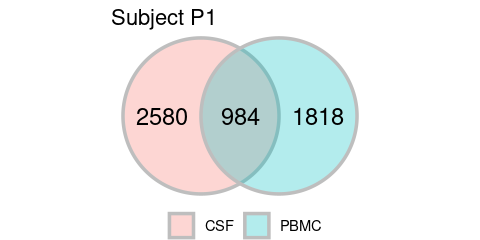

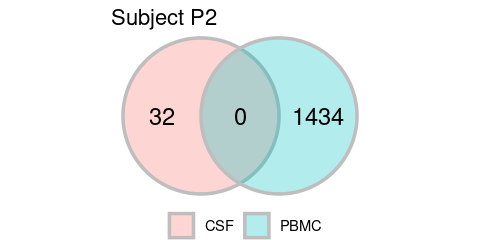

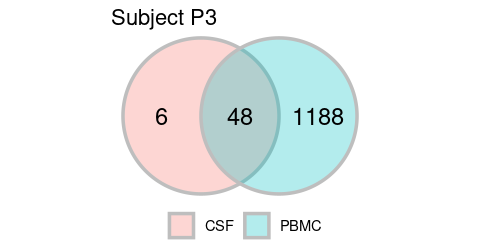

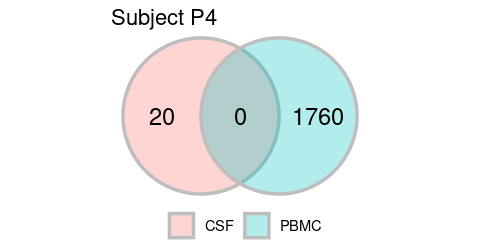

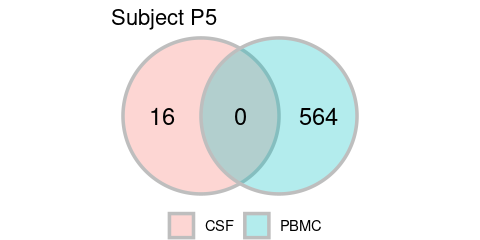

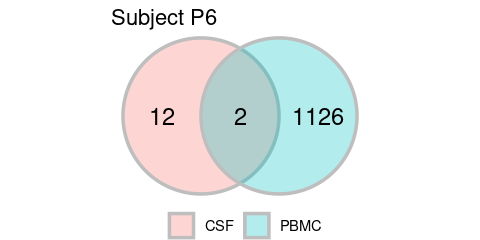

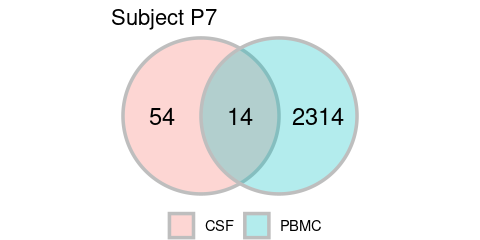

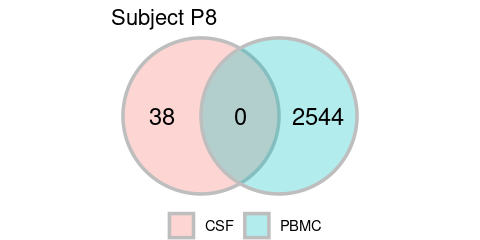

In [38]:
options(repr.plot.width=4, repr.plot.height=2)

df.venn <- data.frame(x = c(-0.5, 0.5),
                          y = c(0,0),
                          labels = c("CSF", "PBMC"))

df.vdc <- data.frame(x = c(-1, 0, 1),
                       y = c(0,0,0))

for(subj in unique(meta_df$SUBJECT)){
    df.vdc <- df.vdc %>%
        mutate(label = overlap_df %>% filter(SUBJECT == subj) %>% select(OVERLAP) %>% unlist())
    
    p <- ggplot(df.venn) +
        geom_circle(aes(x0 = x, y0 = y, r = 1, fill = labels), alpha = .3, size = 1, colour = 'grey') +
        coord_fixed() +
        theme_void() +
        ggtitle(paste("Subject", subj)) +
         theme(legend.position = 'bottom') +
          labs(fill = NULL) +
        annotate("text", x = df.vdc$x, y = df.vdc$y, label = df.vdc$label, size = 5)
    plot(p)
}

In [39]:
overlap_df <- hc_df %>%
    group_by(SUBJECT) %>%
    do(runQuantifyOverlap(., group="LOCATION", clone="CLONE", action="count_bool")  
       %>% mutate_if(is.factor, as.character))

In [40]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'CSF' & LOCATION != 'PBMC')) %>% ungroup()

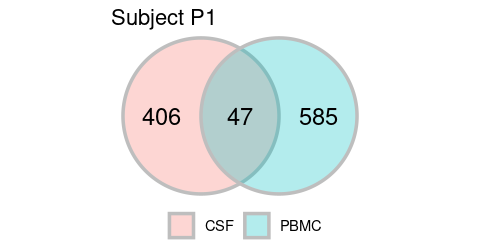

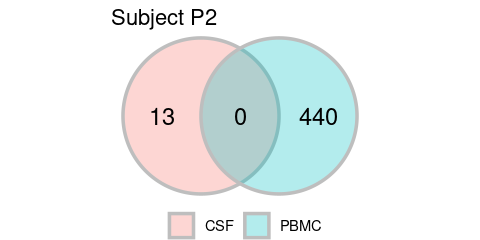

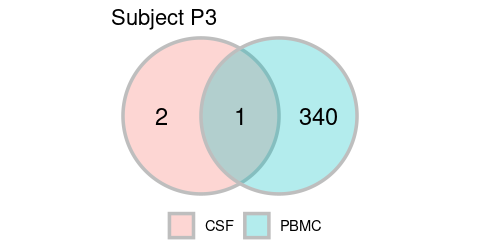

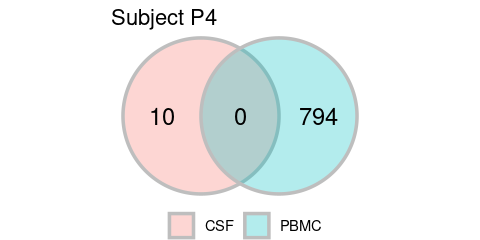

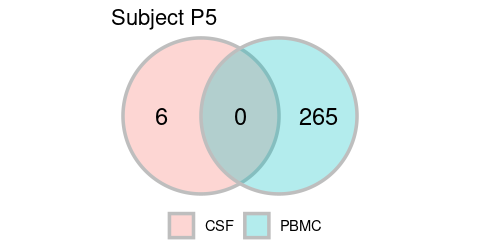

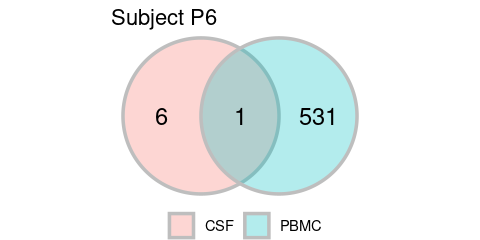

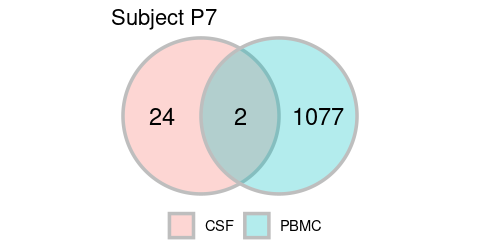

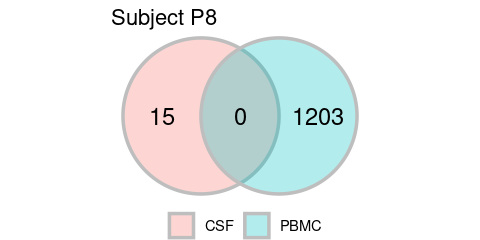

In [41]:
df.venn <- data.frame(x = c(-0.5, 0.5),
                          y = c(0,0),
                          labels = c("CSF", "PBMC"))

df.vdc <- data.frame(x = c(-1, 0, 1),
                       y = c(0,0,0))

for(subj in unique(meta_df$SUBJECT)){
    df.vdc <- df.vdc %>%
        mutate(label = overlap_df %>% filter(SUBJECT == subj) %>% select(OVERLAP) %>% unlist())
    
    p <- ggplot(df.venn) +
        geom_circle(aes(x0 = x, y0 = y, r = 1, fill = labels), alpha = .3, size = 1, colour = 'grey') +
        coord_fixed() +
        theme_void() +
        ggtitle(paste("Subject", subj)) +
         theme(legend.position = 'bottom') +
          labs(fill = NULL) +
        annotate("text", x = df.vdc$x, y = df.vdc$y, label = df.vdc$label, size = 5)
    plot(p)
}

# Directionality/Size Change

In [43]:
df_mu <- hc_df %>%
    rowwise() %>%
    group_by(CLONE, LOCATION, SUBJECT) %>%
    summarize(MU_FREQ = mean(MU_FREQ)) %>%
    spread(LOCATION, MU_FREQ) %>%
    add_colnames(c("CLONE", "SUBJECT", "CSF", "PBMC")) %>%
    na.omit() %>%
    rowwise() %>%
    mutate(DIFF = CSF-PBMC) %>%
    group_by(SUBJECT) %>%
    summarize(DIFF = mean(DIFF), COUNT = n())

`summarise()` regrouping output by 'CLONE', 'LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


In [44]:
# SHM at CSF is higher than PBMC
df_mu

SUBJECT DIFF          COUNT
1 P1      -0.0008051728 47   
2 P3       0.0016627664  1   
3 P6      -0.0144927536  1   
4 P7      -0.0201739783  2

In [46]:
df_size <- hc_df %>%
    rowwise() %>%
    group_by(CLONE, LOCATION, SUBJECT) %>%
    summarize(SIZE = n()) %>%
    group_by( LOCATION, SUBJECT) %>%
    mutate(FREQ = SIZE/sum(SIZE)) %>%
    select(-SIZE) %>%
    spread(LOCATION, FREQ) %>%
    add_colnames(c("CLONE", "SUBJECT", "CSF", "PBMC")) %>%
    na.omit() %>%
    rowwise() %>%
    mutate(DIFF = log(CSF/PBMC)) %>%
    group_by(SUBJECT) %>%
    summarize(DIFF = mean(DIFF), COUNT = n())

`summarise()` regrouping output by 'CLONE', 'LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


In [47]:
# Size at CSF is larger than PBMC
df_size

SUBJECT DIFF      COUNT
1 P1      0.4452063 47   
2 P3      2.1527728  1   
3 P6      4.5415202  1   
4 P7      2.9530299  2

# Features of the compartments

### Request for separate table for P1

In [48]:
abund <- estimateAbundance(hc_df %>% filter(SUBJECT == 'P1'), 
                           group="SUBJECT_LOCATION", clone="CLONE", ci=0.95, nboot=2000, min_n=6)

`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clone)` instead of `clone` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
`summarise()` ungrouping output (override with `.groups` argument)


In [53]:
abund <- abund@abundance %>%
    rowwise() %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


### Abundance P1 

In [57]:
abund <- estimateAbundance(hc_df %>% filter(SUBJECT == 'P1'), 
                           group="SUBJECT_LOCATION", clone="CLONE", ci=0.95, nboot=2000, min_n=6)

abund <- abund@abundance %>%
    rowwise() %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


In [59]:
abund_span <- abund %>% filter(!grepl("U", CLONE)) %>%
    mutate(CLONE = as.character(CLONE)) %>%
    left_join(
        hc_df %>%
            select(CLONE, SUBJECT, LOCATION, SPAN) %>% distinct()
    )

Adding missing grouping variables: `CELL`, `SAMPLE`
Joining, by = c("CLONE", "SUBJECT", "LOCATION")


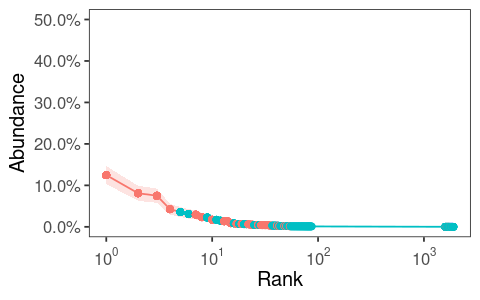

In [60]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund_span %>% filter(LOCATION == "CSF", SUBJECT == "P1"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), 
          axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), 
          strip.text=element_text(size=12), legend.text=element_text(size=10), 
          legend.title=element_text(size=12), legend.position="none") +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.5, 0.1), limits=c(0,0.5)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=SUBJECT), alpha=0.2) +
    geom_line(aes(color=SPAN), size=0.5) +
    geom_point(aes(color=SPAN)) 
plot(p)

In [32]:
plotFigure(p, file.path(BASE_DIR, "figures", "bcr_abundance_mobile_csf_nolegend.pdf"), 4, 2.5)

png 
  2

In [26]:
abund_span %>% filter(LOCATION == "CSF", SUBJECT == "P1") %>% 
    write.csv(file.path(BASE_DIR, "figures/bcr_abundance_mobile_csf.csv"))

In [61]:
wilcox.test(
    filter(abund_span, LOCATION == "PBMC", SUBJECT == "P1", SPAN == "Resident")$P,
    filter(abund_span, LOCATION == "PBMC", SUBJECT == "P1", SPAN == "Mobile")$P)


	Wilcoxon rank sum test with continuity correction

data:  filter(abund_span, LOCATION == "PBMC", SUBJECT == "P1", SPAN ==  and filter(abund_span, LOCATION == "PBMC", SUBJECT == "P1", SPAN ==     "Resident")$P and     "Mobile")$P
W = 11420, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


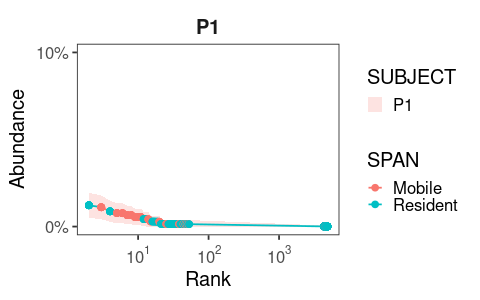

In [62]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund_span %>% filter(LOCATION == "PBMC", SUBJECT == "P1", RANK != 1), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme( axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.5, 0.1), limits=c(0,0.1)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=SUBJECT), alpha=0.2) +
    geom_line(aes(color=SPAN), size=0.5) +
    geom_point(aes(color=SPAN)) +
    facet_grid(. ~ SUBJECT)
plot(p)

In [63]:
abund %>%
    group_by(SUBJECT, LOCATION) %>%
    filter(P == max(P))

SUBJECT_LOCATION CLONE   P         P_SD       LOWER     UPPER     RANK
1 P1,CSF           21_1    0.1247420 0.01106815 0.1030489 0.1464352 1   
2 P1,PBMC          176_189 0.2320231 0.01399367 0.2045960 0.2594502 1   
  SUBJECT LOCATION STATUS
1 P1      CSF      N     
2 P1      PBMC     N

In [172]:
abund %>%
    group_by(SUBJECT, LOCATION) %>%
    filter(P == max(P)) %>% write.csv(file.path(TABLES_DIR, "bcr_largest_clone.csv"))

### Abundance all subjects

In [9]:
abund <- estimateAbundance(hc_df, 
                           group="SUBJECT_LOCATION", clone="CLONE", ci=0.95, nboot=500, min_n=6)

abund <- abund@abundance %>%
    rowwise() %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clone)` instead of `clone` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "SUBJECT"


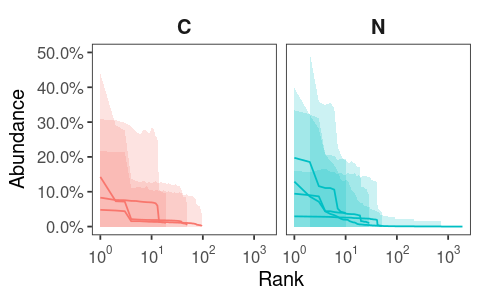

In [10]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(LOCATION == "CSF"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.5, 0.1), limits=c(0,0.5)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ STATUS)
plot(p)

In [34]:
plotFigure(p, file.path(BASE_DIR, "figures", "bcr_abundance_csf_nolegend.pdf"), 4, 2.5)

png 
  2

In [36]:
abund %>% filter(LOCATION == "CSF") %>% 
    write.csv(file.path(BASE_DIR, "figures/bcr_abundance_csf.csv"))

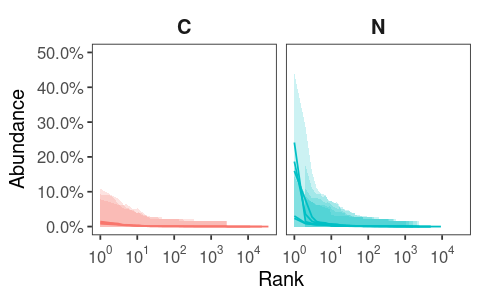

In [11]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(LOCATION == "PBMC"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.5, 0.1), limits=c(0,0.5)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ STATUS)
plot(p)

In [35]:
plotFigure(p, file.path(BASE_DIR, "figures", "bcr_abundance_pbmc_nolegend.pdf"), 4, 2.5)

png 
  2

In [37]:
abund %>% filter(LOCATION == "PBMC") %>% 
    write.csv(file.path(BASE_DIR, "figures/bcr_abundance_pbmc.csv"))

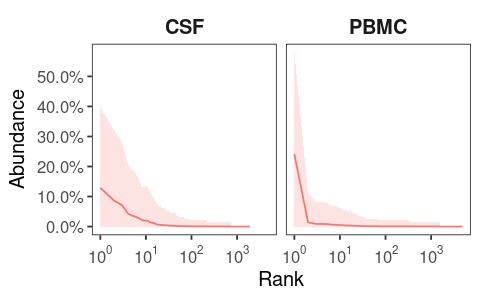

In [12]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(SUBJECT == "P1"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.5, 0.1)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ LOCATION)
plot(p)

In [13]:
div <- alphaDiversity(hc_df %>% ungroup(), group="SUBJECT_LOCATION", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=2000, min_n=6)

`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)


In [14]:
even <- div@diversity %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


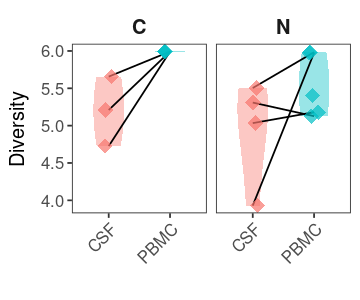

In [15]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

In [149]:
even %>% 
    filter(Q==2) %>% 
    select(D, SUBJECT, LOCATION, STATUS) %>% 
    arrange(LOCATION) %>% write.csv(file.path(TABLES_DIR, "bcr_simpson_diversity.csv"))

Adding missing grouping variables: `subject_location`


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


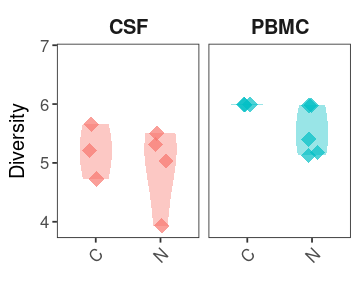

In [16]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=STATUS, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ LOCATION)
plot(p)

In [42]:
plotFigure(p, file.path(BASE_DIR, "figures", "bcr_even.pdf"), 3, 2.5)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


png 
  2

In [44]:
even %>% filter(Q==2) %>%
    write.csv(file.path(BASE_DIR, "figures/bcr_even.csv"))

In [17]:
isotype_tab <- hc_df %>%
    group_by(LOCATION, SUBJECT, C_CALL, STATUS) %>%
    summarize(COUNT=n()) %>%
    group_by(LOCATION, SUBJECT, STATUS) %>%
    mutate(FREQ=COUNT/sum(COUNT, na.rm=T))  %>%
    group_by(C_CALL) %>%
    complete(nesting(SUBJECT, STATUS), LOCATION, fill = list(COUNT = 0, FREQ = 0)) %>% 
    filter(C_CALL != "")

`summarise()` regrouping output by 'LOCATION', 'SUBJECT', 'C_CALL' (override with `.groups` argument)


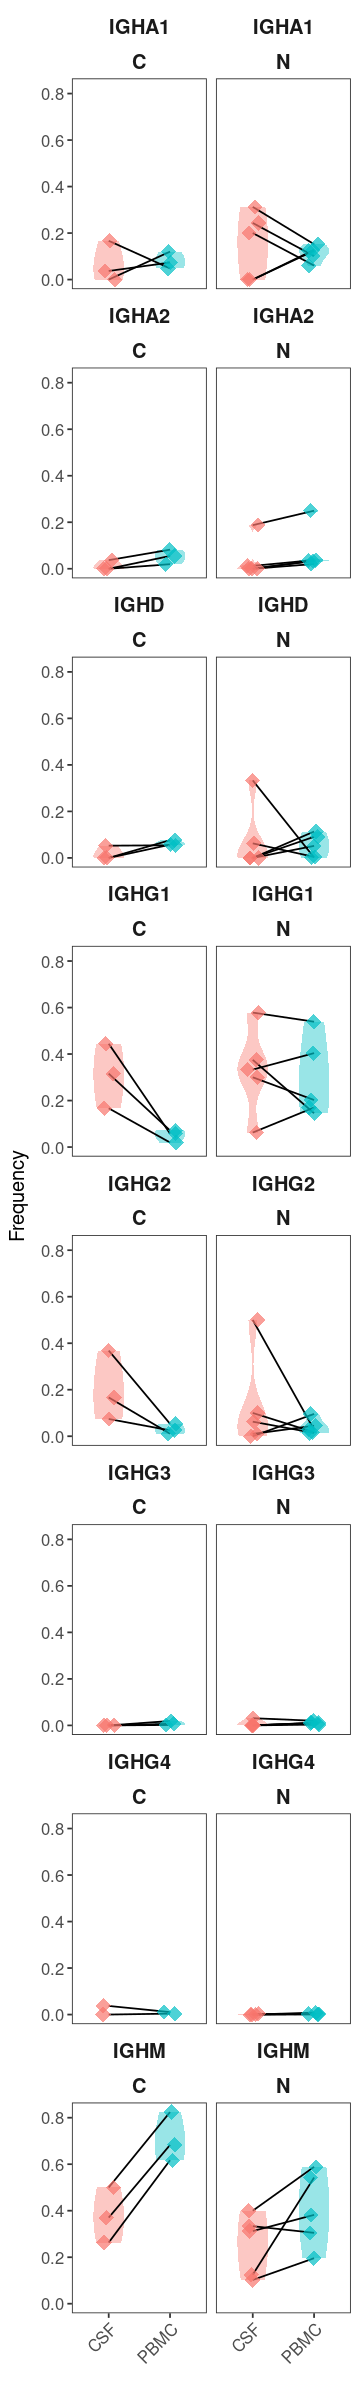

In [20]:
options(repr.plot.width=3, repr.plot.height=20)

p <- ggplot(isotype_tab, aes(x=LOCATION, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ C_CALL + STATUS, ncol=2, nrow=9)
plot(p)

In [153]:
isotype_tab %>% write.csv(file.path(TABLES_DIR, "bcr_ccall.csv"))

In [21]:
mu_tab <- hc_df %>%
    group_by(LOCATION, SUBJECT, C_CALL, STATUS) %>%
    summarize(FREQ=mean(MU_FREQ))  %>%
    complete(nesting(SUBJECT, STATUS), LOCATION, fill = list(FREQ = NA)) %>% 
    filter(C_CALL != "")

`summarise()` regrouping output by 'LOCATION', 'SUBJECT', 'C_CALL' (override with `.groups` argument)


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


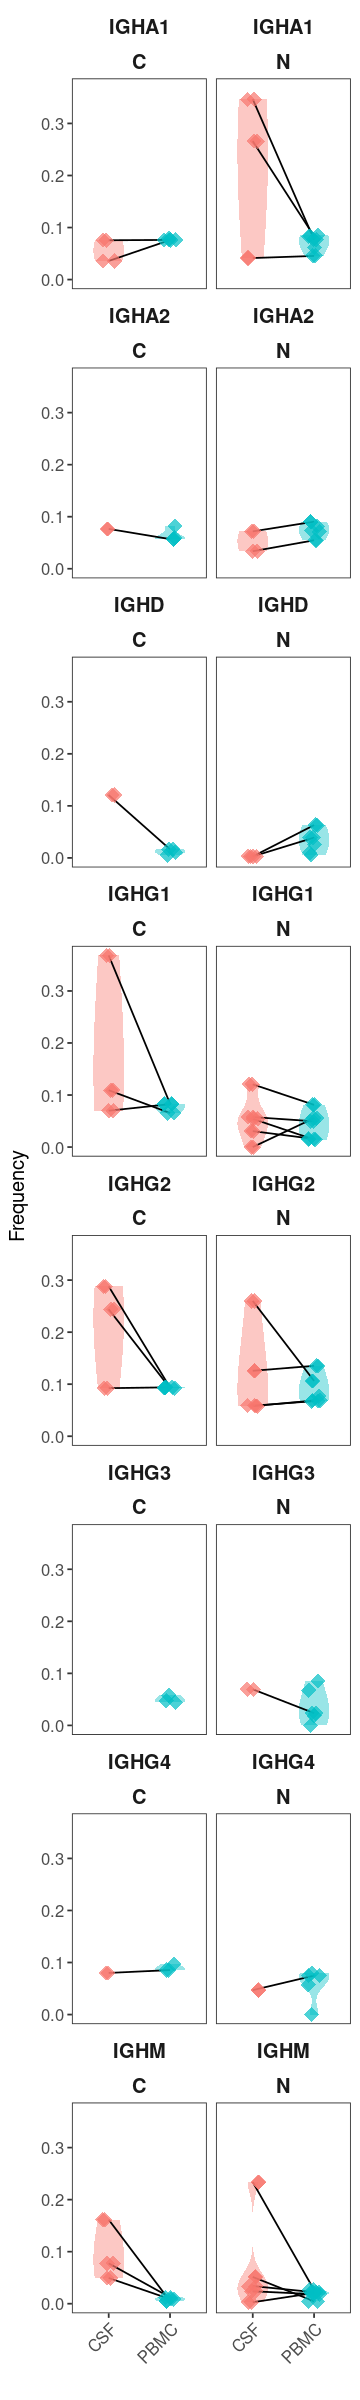

In [24]:
options(repr.plot.width=3, repr.plot.height=20)

p <- ggplot(mu_tab %>% drop_na(), aes(x=LOCATION, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ C_CALL + STATUS, ncol=2, nrow=9)
plot(p)

In [159]:
mu_tab %>% write.csv(file.path(TABLES_DIR, "bcr_shm.csv"))

# Features of the overlap

In [26]:
div_span <- alphaDiversity(hc_df %>% mutate(SUBJECT_LOCATION_SPAN = paste(SUBJECT_LOCATION, SPAN, sep="@")), 
                           group="SUBJECT_LOCATION_SPAN", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=2000, min_n=6)

`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)


In [27]:
even_span <- div_span@diversity %>%
    rowwise() %>%
    mutate(SUBJECT_LOCATION = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][1], 
           span = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][2]) %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


In [163]:
even_span %>% 
    filter(Q==2) %>% 
    select(D, SUBJECT, LOCATION, STATUS, span) %>% 
    arrange(LOCATION) %>% 
    arrange(LOCATION) %>% write.csv(file.path(TABLES_DIR, "bcr_simpson_diversity_span.csv"))

Adding missing grouping variables: `subject_location_span`


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


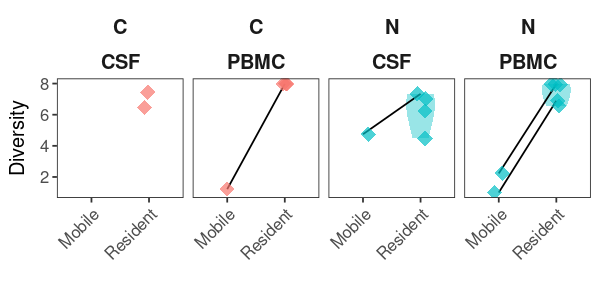

In [28]:
options(repr.plot.width=5, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2), aes(x=span, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS+LOCATION)
plot(p)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


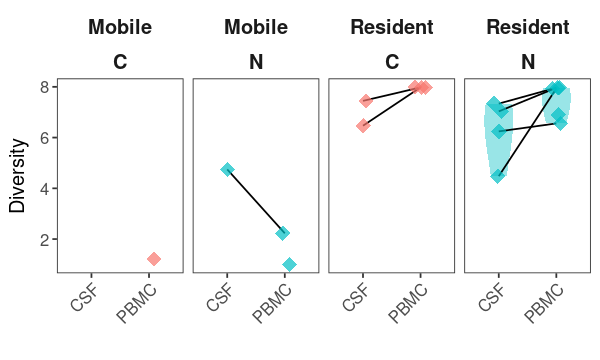

In [29]:
options(repr.plot.width=5, repr.plot.height=3)

p <- ggplot(even_span %>% filter(Q==2), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ span+STATUS)
plot(p)

In [34]:
isotype_span_tab <- hc_df %>%
    group_by(STATUS, SUBJECT, C_CALL, SPAN, LOCATION) %>%
    summarize(COUNT=n()) %>%
    group_by(STATUS, SUBJECT, SPAN, LOCATION) %>%
    mutate(FREQ=COUNT/sum(COUNT, na.rm=T)) %>%
    group_by(C_CALL) %>%
    complete(nesting(STATUS, SUBJECT), LOCATION, SPAN, fill = list(COUNT = 0, FREQ = 0)) 

`summarise()` regrouping output by 'STATUS', 'SUBJECT', 'C_CALL', 'SPAN' (override with `.groups` argument)


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path:

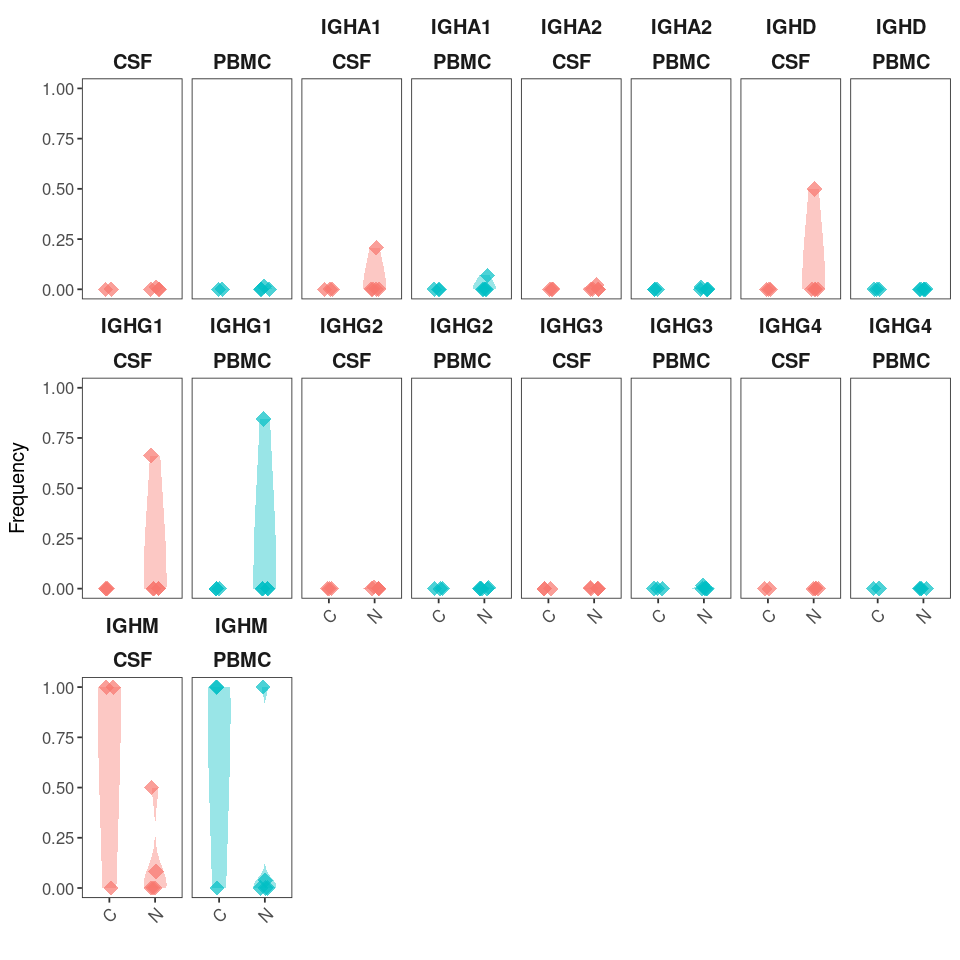

In [36]:
options(repr.plot.width=8, repr.plot.height=8)

p <- ggplot(isotype_span_tab %>% filter(SPAN=="Mobile"), aes(x=STATUS, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ C_CALL+LOCATION, ncol=8, nrow=4)
plot(p)

In [165]:
isotype_span_tab %>% filter(span=="Mobile") %>% 
    write.csv(file.path(TABLES_DIR, "bcr_ccall_span.csv"))

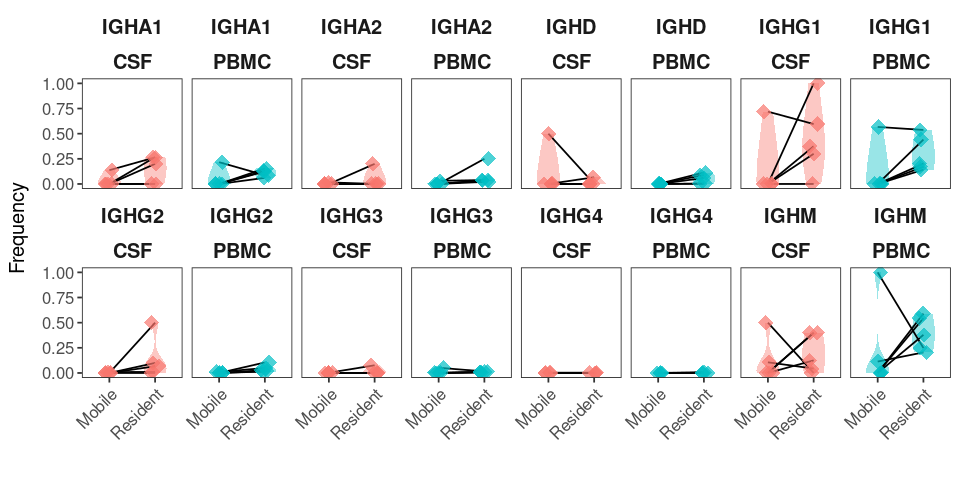

In [367]:
options(repr.plot.width=8, repr.plot.height=4)

p <- ggplot(isotype_span_tab %>% filter(C_CALL != "", status=="N"), aes(x=SPAN, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ C_CALL+LOCATION, ncol=8, nrow=4)
plot(p)

In [166]:
mu_span_tab <- hc_df %>%
    group_by(STATUS, SUBJECT, C_CALL, SPAN, LOCATION) %>%
    summarize(FREQ=mean(MU_FREQ)) %>%
    complete(nesting(STATUS, SUBJECT), LOCATION, fill = list(FREQ = NA)) %>% 
    filter(C_CALL != "", STATUS=="N")

`summarise()` regrouping output by 'status', 'subject', 'c_call', 'span' (override with `.groups` argument)


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


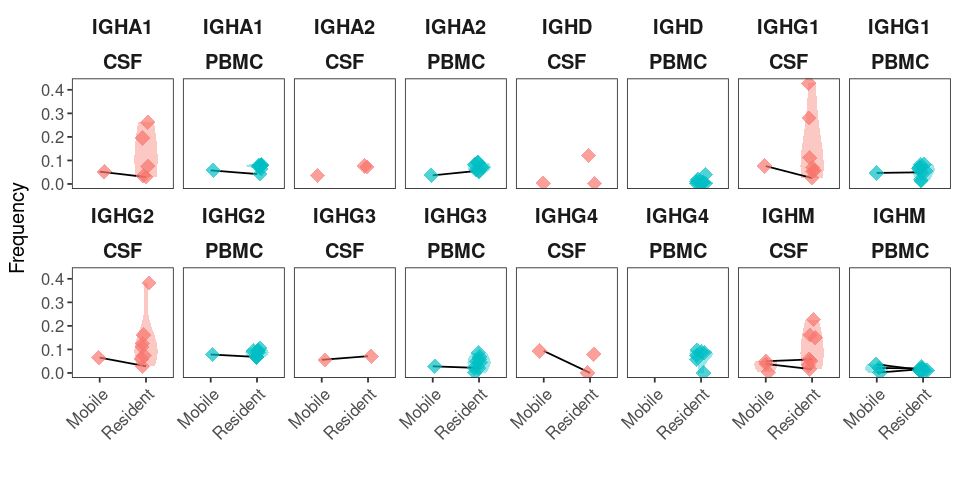

In [167]:
options(repr.plot.width=8, repr.plot.height=4)

p <- ggplot(mu_span_tab %>% drop_na(), aes(x=SPAN, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ C_CALL+LOCATION, ncol=8, nrow=4)
plot(p)

In [168]:
mu_span_tab %>% write.csv(file.path(TABLES_DIR, "bcr_shm_span.csv"))

# Trees (6 hrs to run, 300 trees)

In [374]:
input <- hc_df %>% 
    filter(SPAN == "Mobile") %>%
    rowwise() %>%
    mutate(SEQUENCE_ID = strsplit(as.character(SEQUENCE_ID), split="-1_contig")[[1]][1]) %>%
    filter(grepl("IGH", C_CALL)) %>%
    mutate(CLONE = paste(SUBJECT, CLONE, sep='_')) 

### iGraph Based Trees

In [99]:
output <- input %>% runBuildTrees(format="changeo", graph_format="graph") 
output %>% saveRDS(file.path(BASE_DIR, "trees_graph.rds"))

In [ ]:
trees <- readRDS(file.path(BASE_DIR, "trees_graph.rds"))$trees

In [100]:
trees <- output$trees

In [39]:
# lung is blue
STATUS_COLORS <- c(
'L' = '#6495ED',
'M' = '#FFBD33'
)

In [53]:
# try to get a count based on the size of the vertex

# parameters, VCOLOR, VTEXT

pdf(file.path(BASE_DIR, "trees.pdf"),40,40)

for(clone in names(trees)){
    g <- trees[[clone]]

    plot_df <- data.frame(SEQUENCE_ID = V(g)$name) %>% 
        rowwise() %>%
        mutate(NAME = if(grepl("GERM", SEQUENCE_ID)){"Germline"}else{SEQUENCE_ID}) %>%
        mutate(SEQUENCE_ID = strsplit(as.character(SEQUENCE_ID), split = '_')[[1]][1]) %>%
        left_join(input %>% filter(CLONE == clone) %>% select(SEQUENCE_ID, C_CALL, STATUS, CLUSTER), 
                 by='SEQUENCE_ID') %>%
        rowwise() %>%
        mutate(VERTEX_COLOR = STATUS_COLORS[as.character(STATUS)]) %>%
        mutate(TEXT = if(is.na(VERTEX_COLOR)){""}else{paste(as.character(C_CALL, as.character(CLUSTER), sep = ",")}) %>%
        mutate(VERTEX_SHAPE = "circle") %>%
        mutate(VERTEX_COLOR = if(is.na(VERTEX_COLOR)){"#FFFFFF"}else{VERTEX_COLOR}) %>%
        mutate(VERTEX_COLOR = if(NAME == "Germline"){"#000000"}else{VERTEX_COLOR}) %>%
        mutate(VERTEX_SIZE = if(NAME == "Germline" | grepl("^[0-9]*$", NAME)){1}else{2}) %>%
        mutate(VERTEX_LABEL = if(grepl("^[0-9]*$", NAME)){""}else{TEXT}) 

    V(g)$name <- plot_df$NAME 
    V(g)$shape <- plot_df$VERTEX_SHAPE 
    V(g)$label <- plot_df$VERTEX_LABEL
    V(g)$size <- plot_df$VERTEX_SIZE
    V(g)$color <- plot_df$VERTEX_COLOR
    V(g)$label.cex <- 0.3

    E(g)$label <- E(g)$weight
    E(g)$label.cex <- 0.3  

     # Plot graph as a tree
    options(repr.plot.height=20, repr.plot.width=20)
    ly <- layout.reingold.tilford(g, root="Germline", circular=F, flip.y=T)
    
    plot(g, layout=ly,
             rescale=T,
             edge.arrow.mode=0, 
             vertex.label.family="Helvetica",
             edge.label.color="black", 
             vertex.frame.color="black",
             vertex.label.color="black",
            vertex.label.family="Helvetica") + title(clone)
    
}
dev.off()

Warning message in mutate_impl(.data, dots, caller_env()):
“binding factor and character vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercin

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.data, dots, caller_env()):
“binding character and factor vector, coercing into character vector”Warning message in mutate_impl(.dat

png 
  2

## phylo based trees

In [375]:
# csf is blue
LOCATION_COLORS <- c(
'CSF' = '#6495ED',
'PBMC' = '#FFBD33',
'Root' = "#888888"
)

In [376]:
output <- input %>% runBuildTrees(format="changeo", graph_format="phylo", collapse=FALSE) 

In [377]:
output %>% saveRDS(file.path(BASE_DIR, "trees_phylo_nocollapse.rds"))

In [422]:
output <- readRDS(file.path(BASE_DIR, "trees_phylo_nocollapse.rds"))

In [423]:
trees <- output$trees

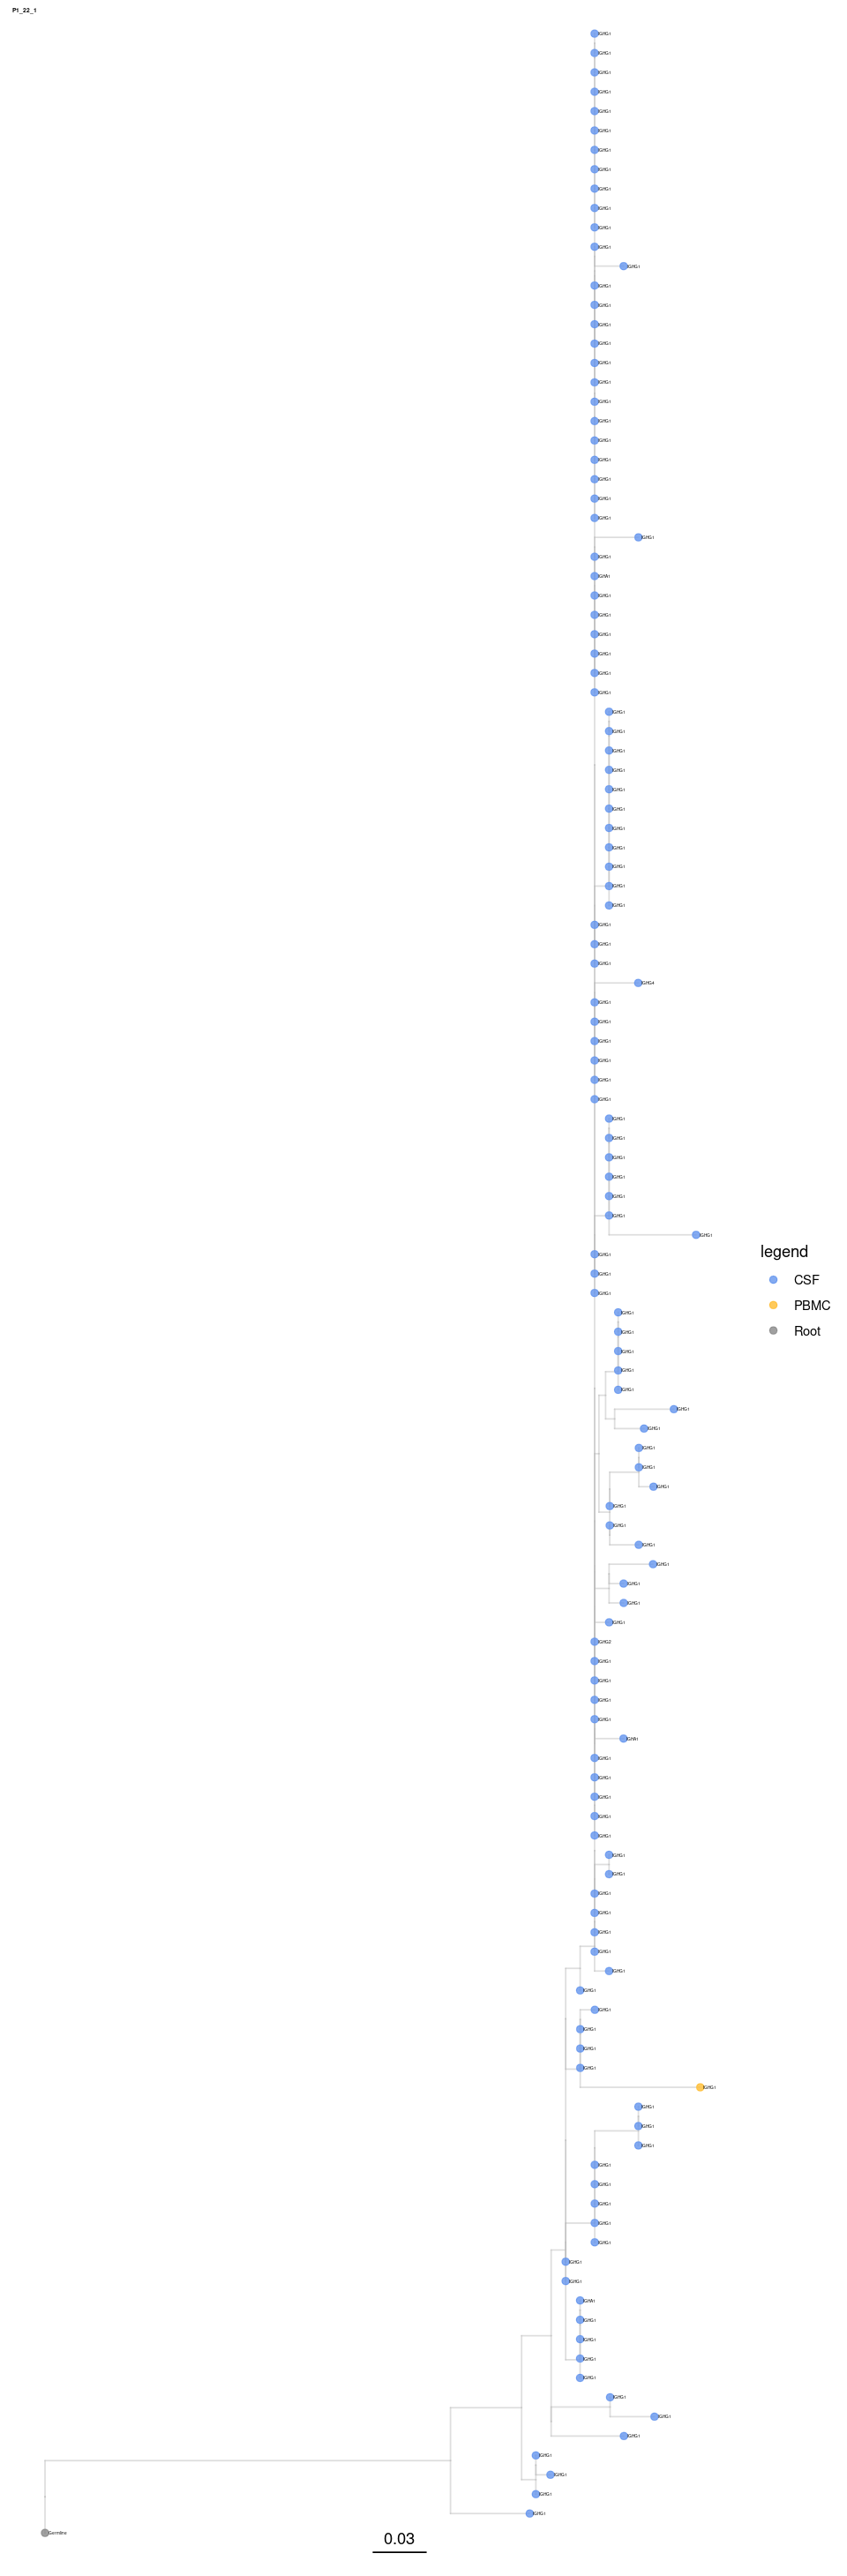

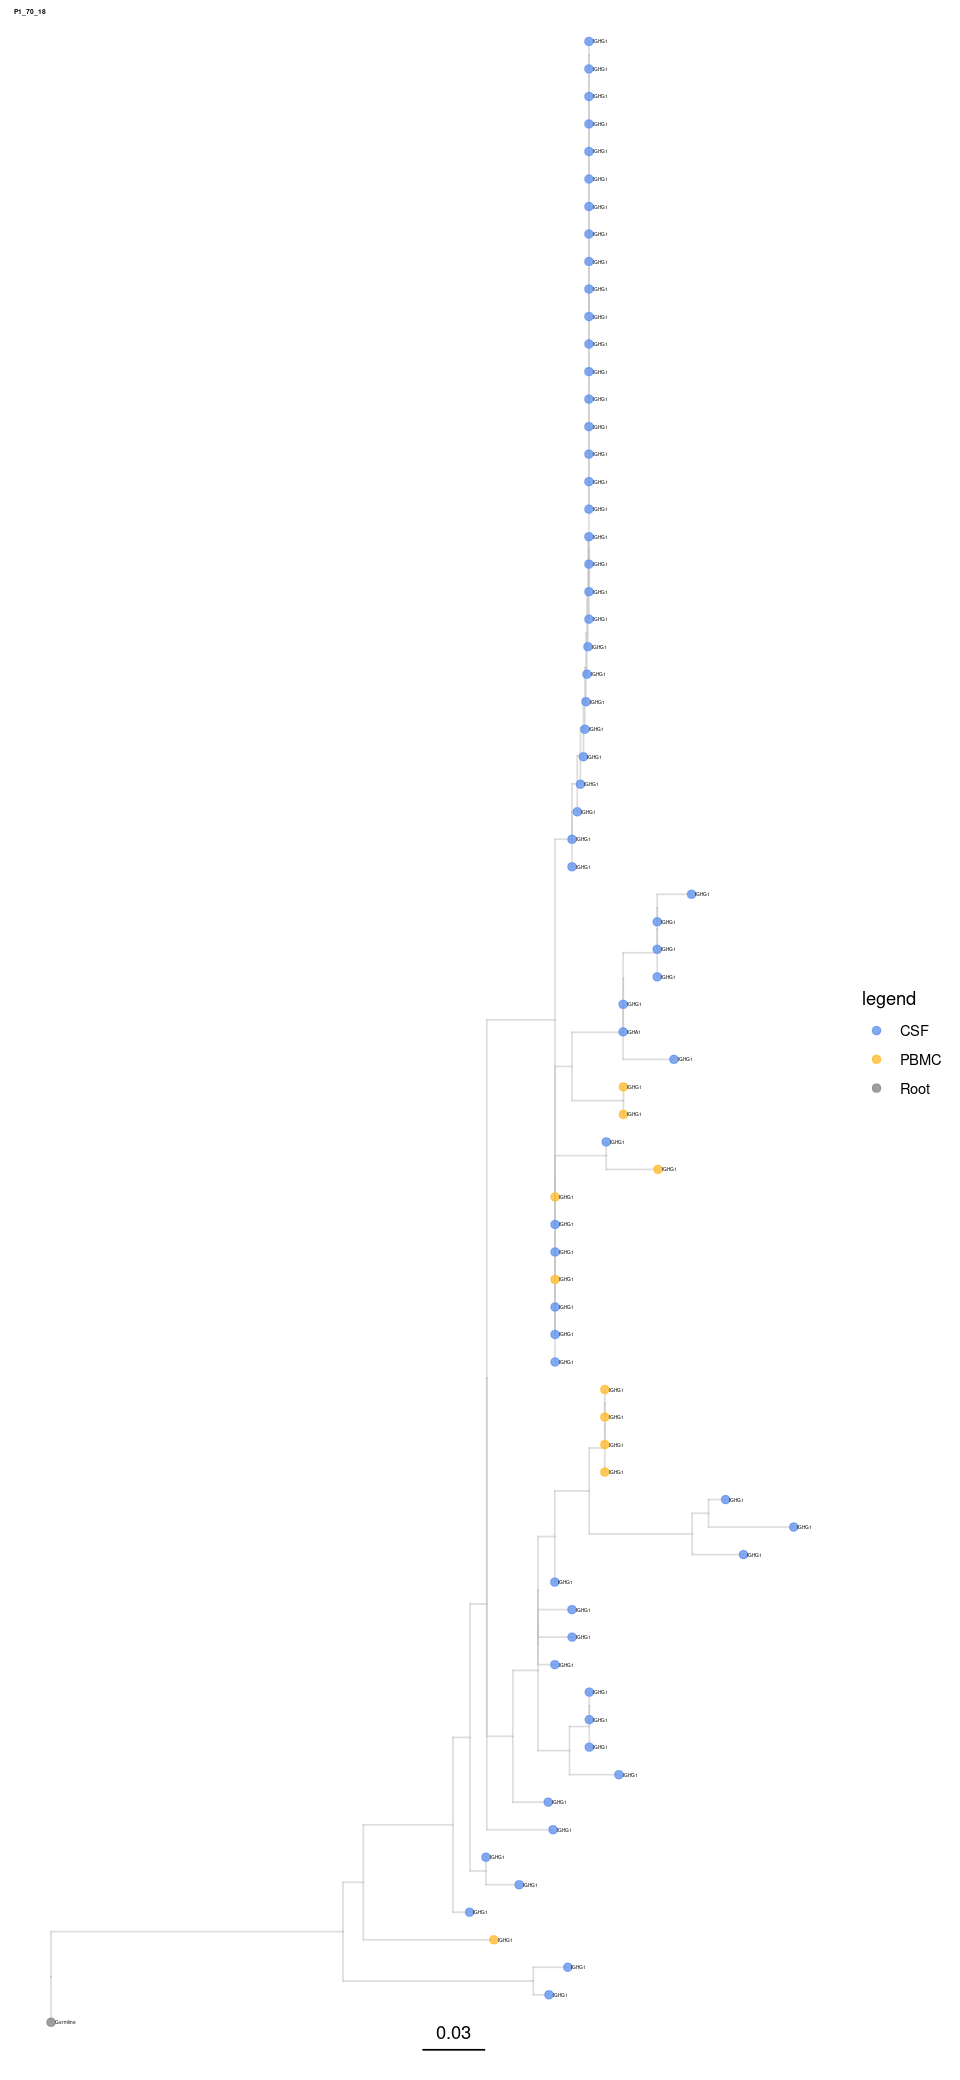

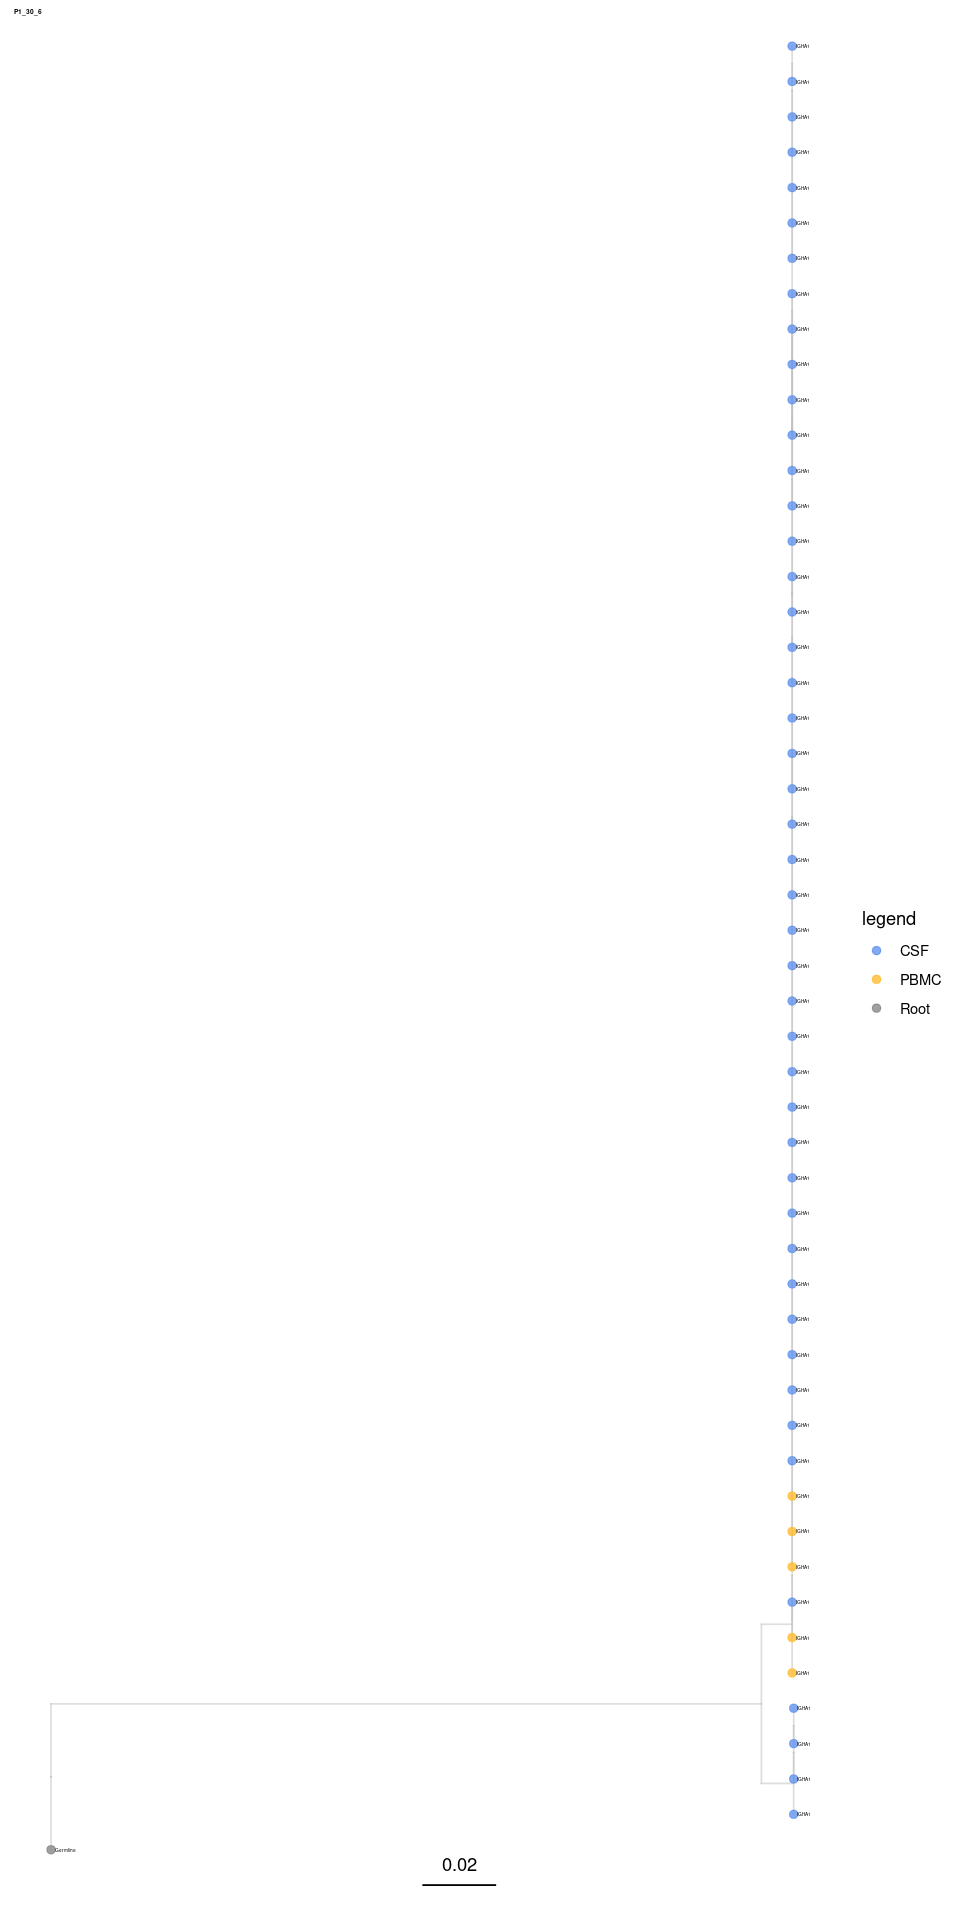

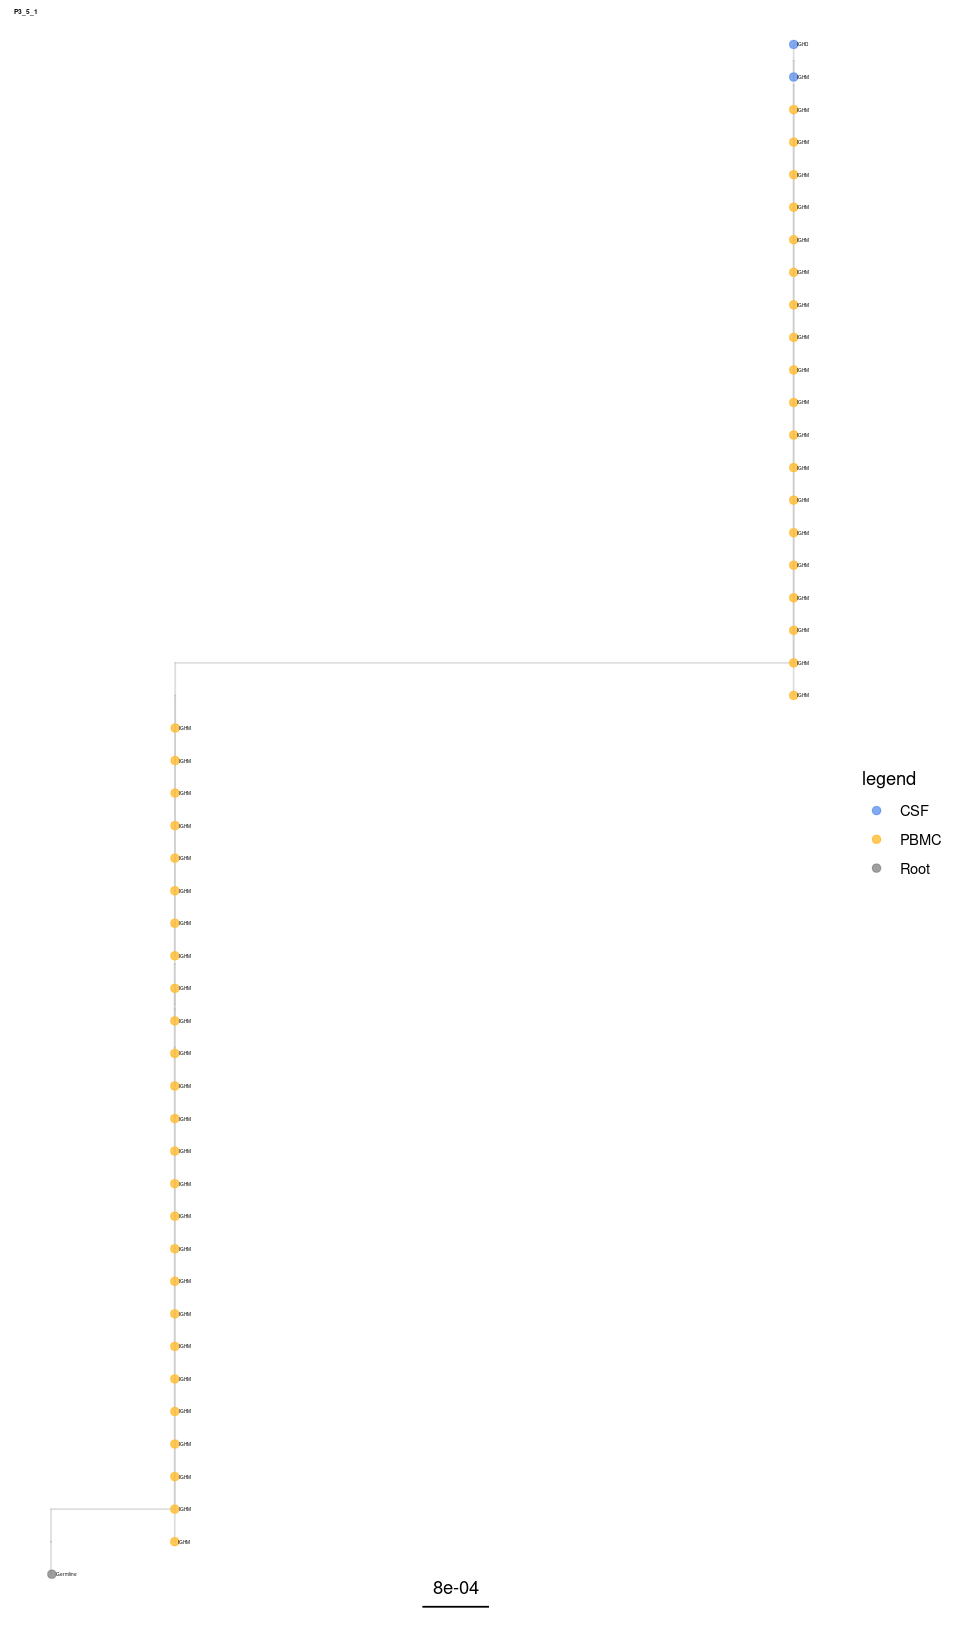

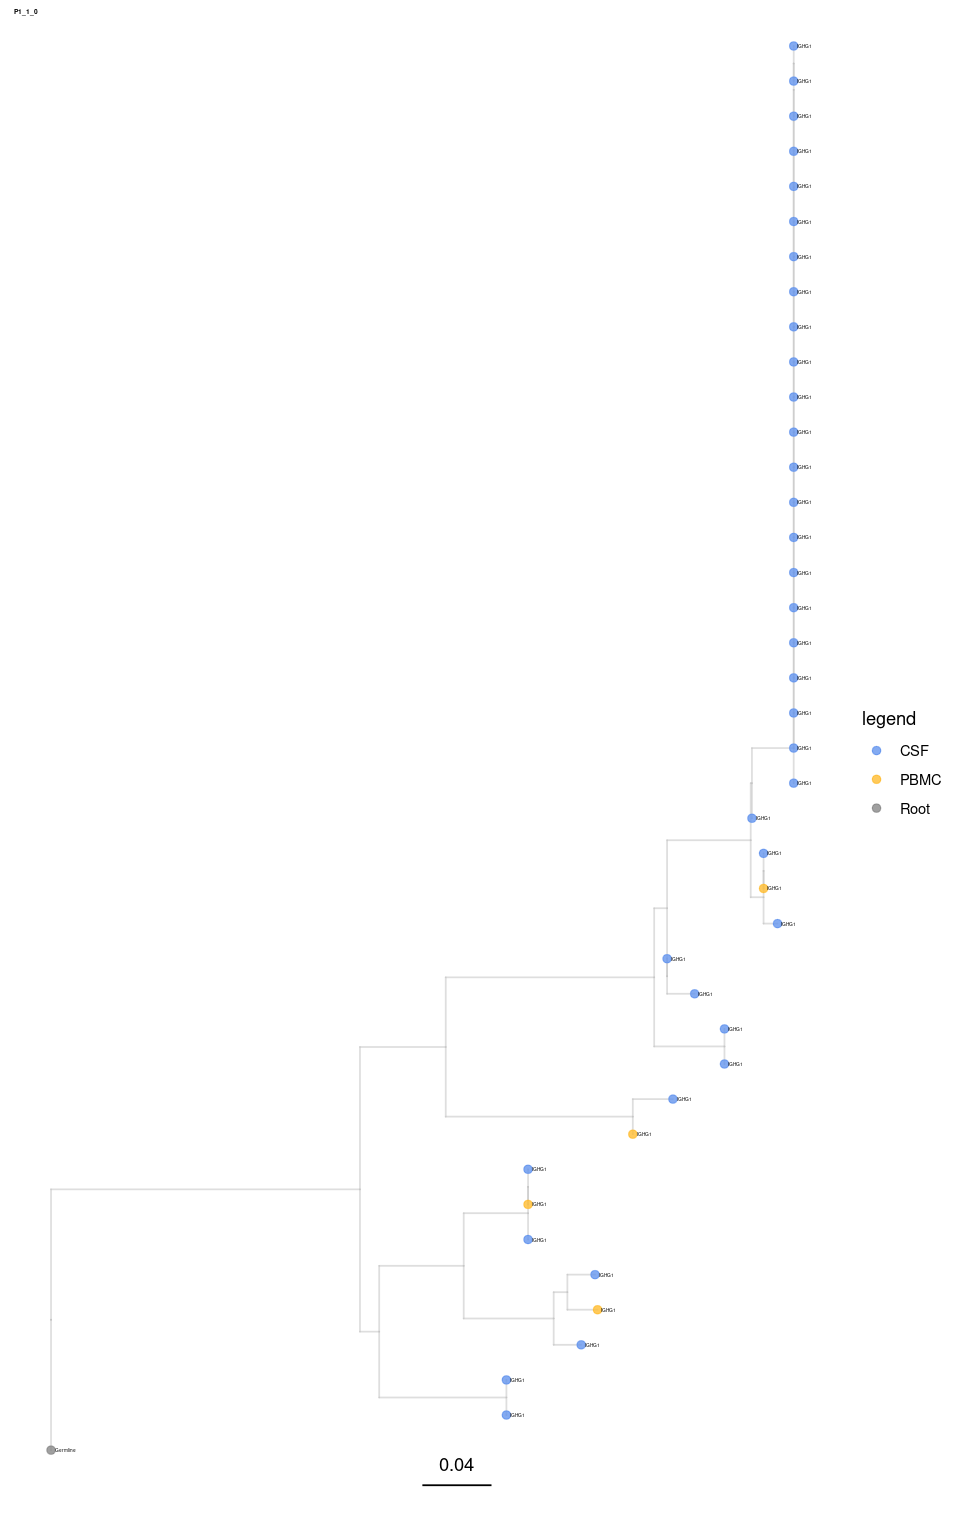

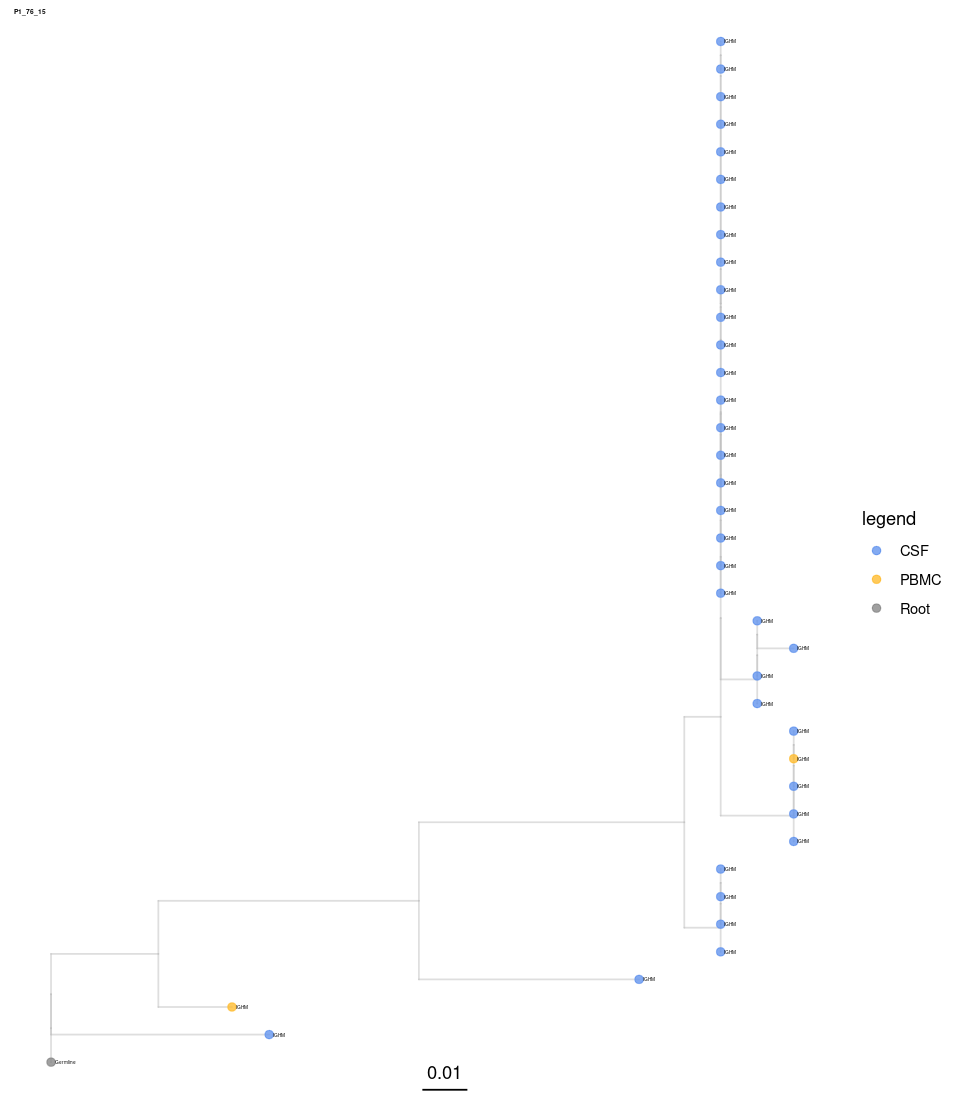

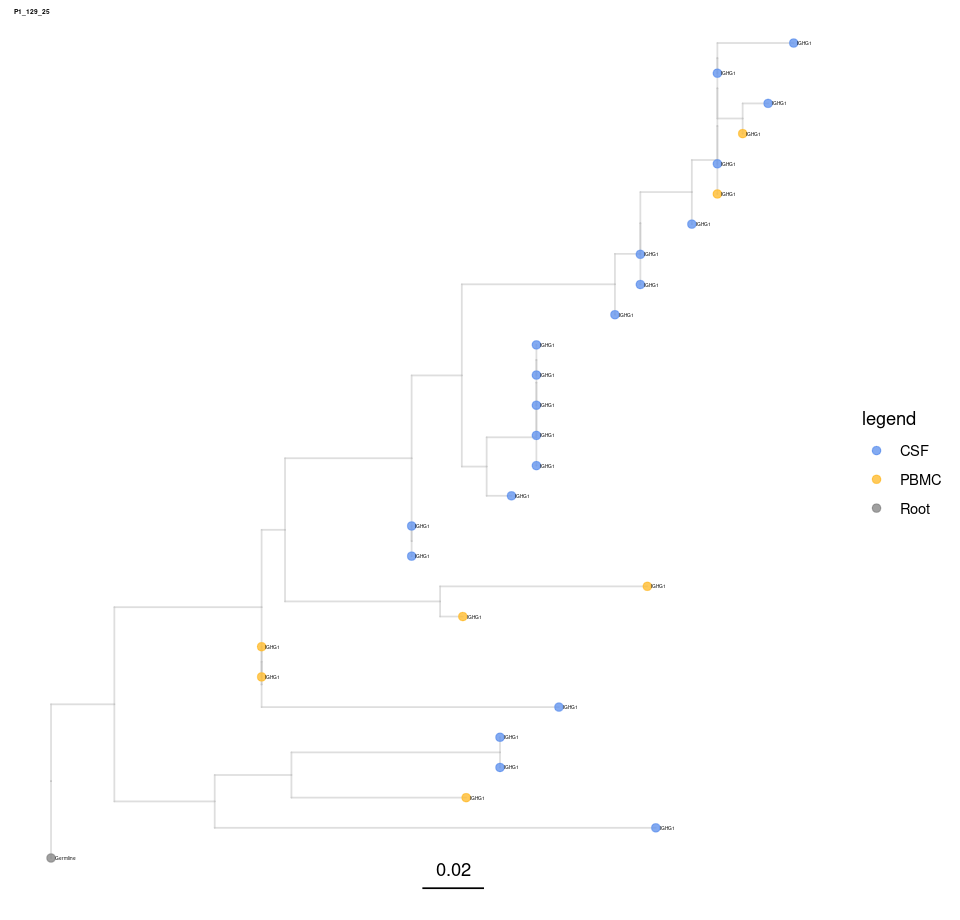

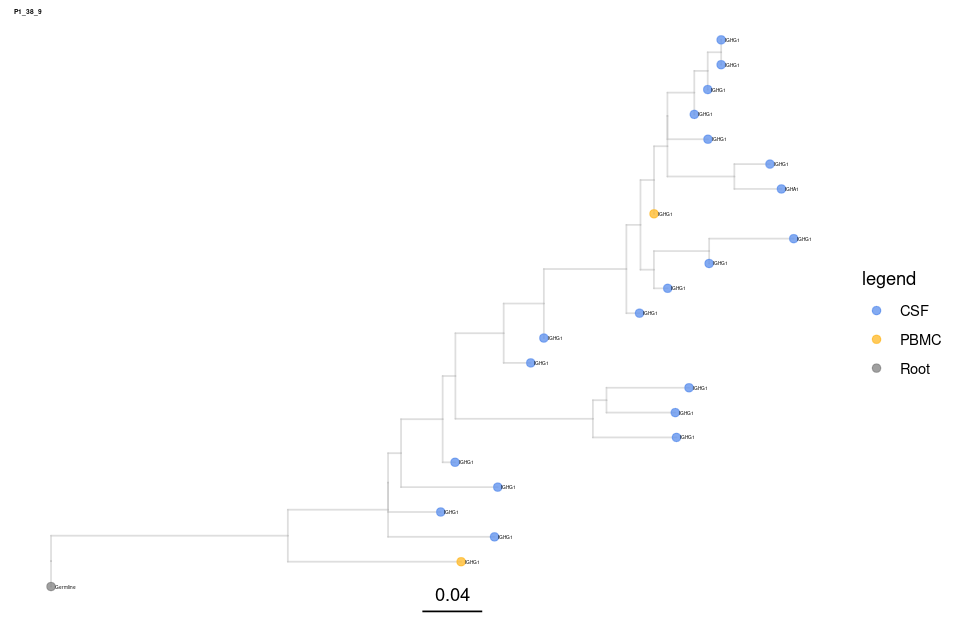

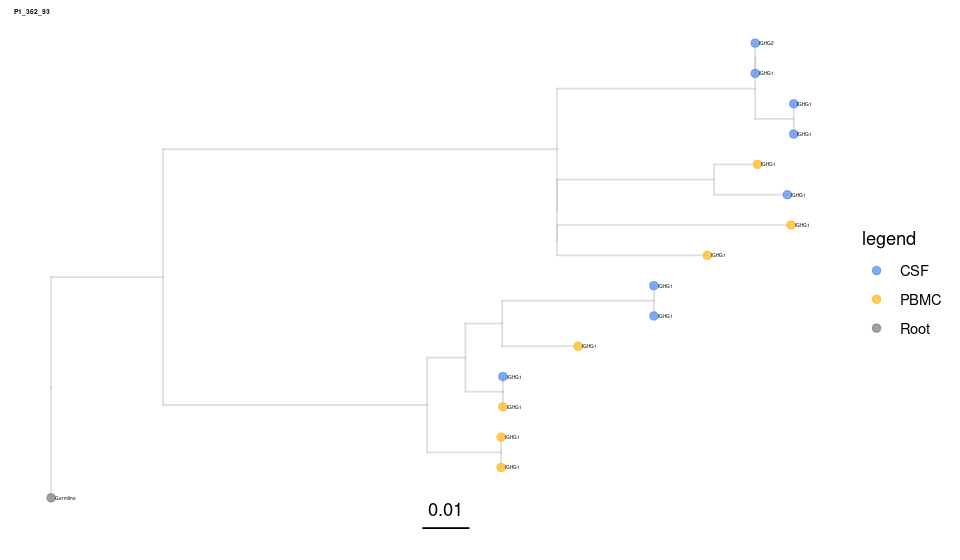

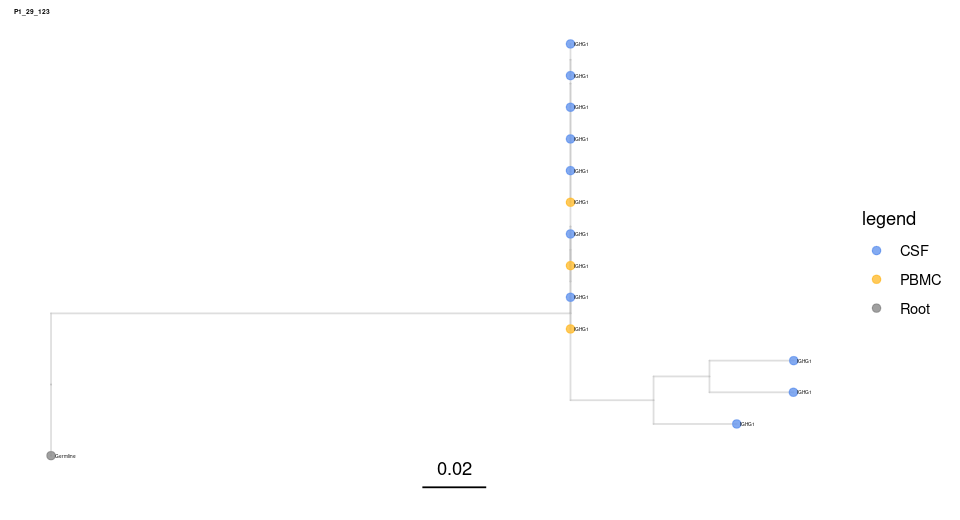

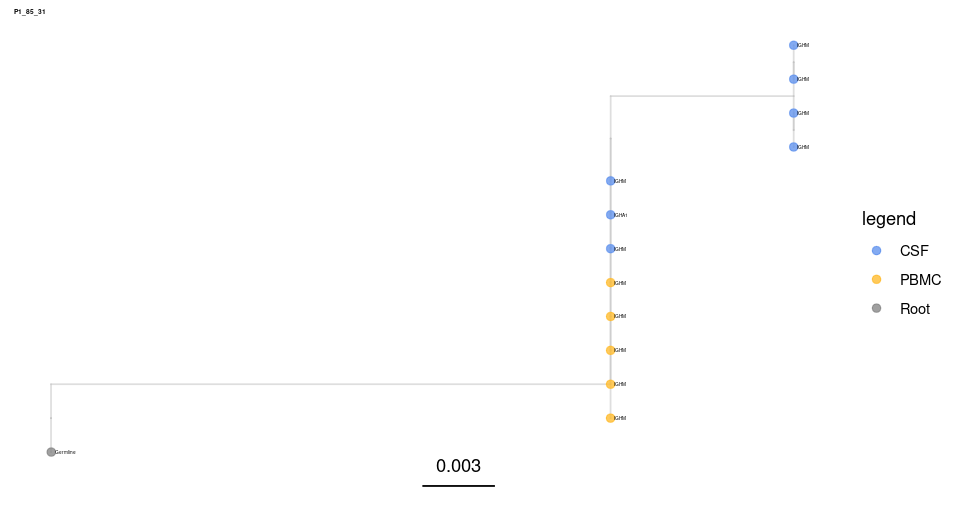

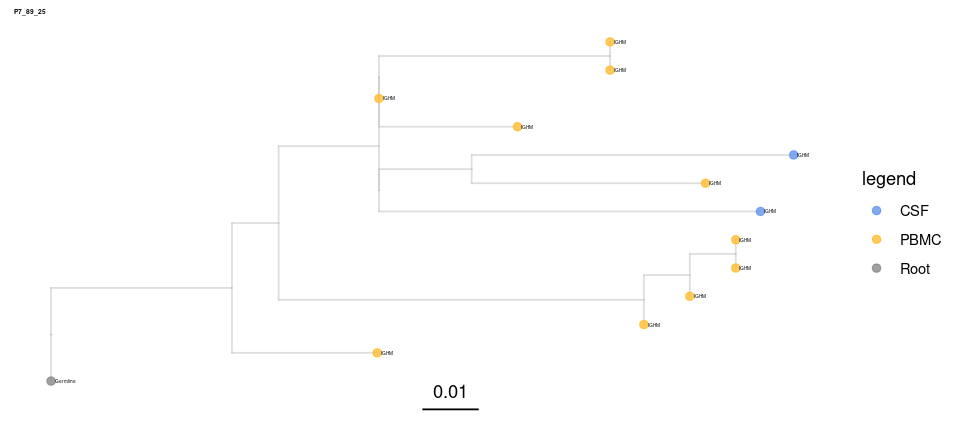

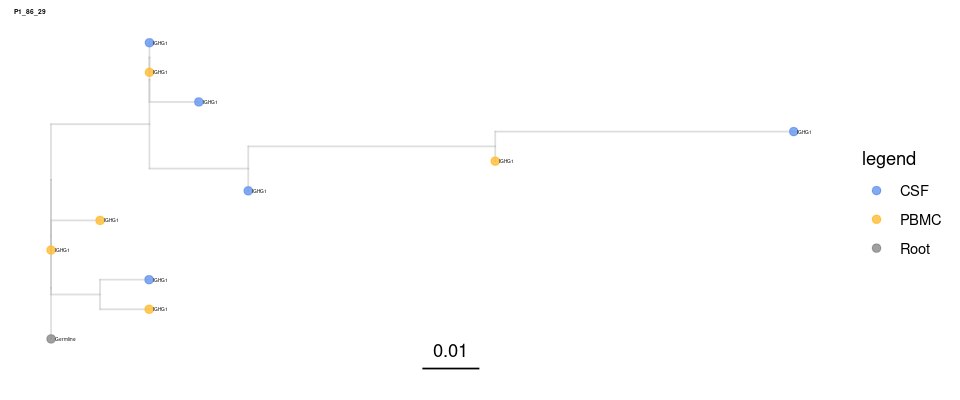

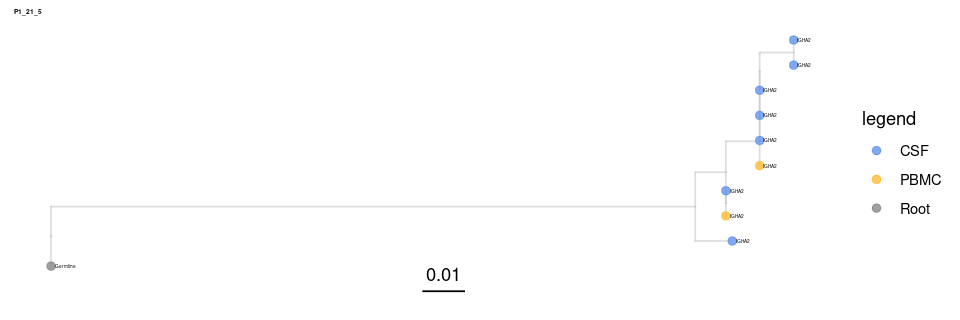

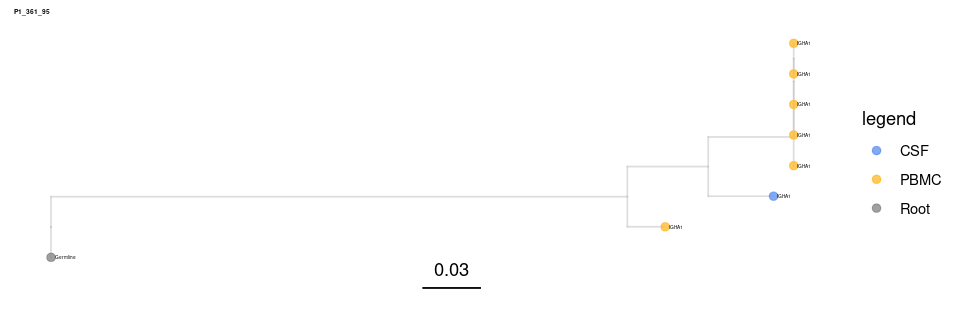

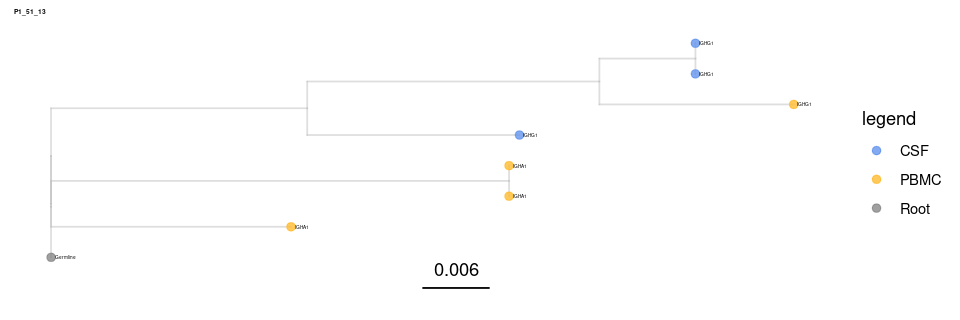

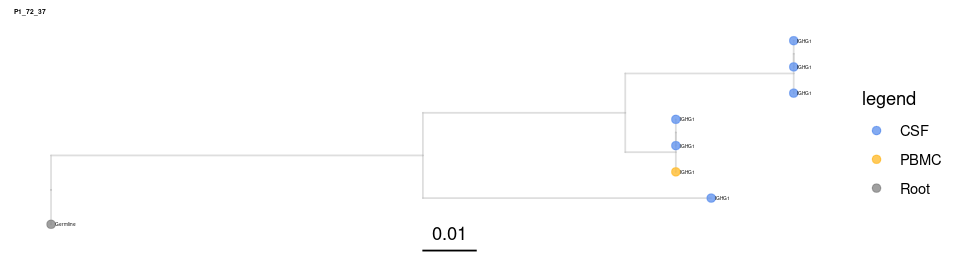

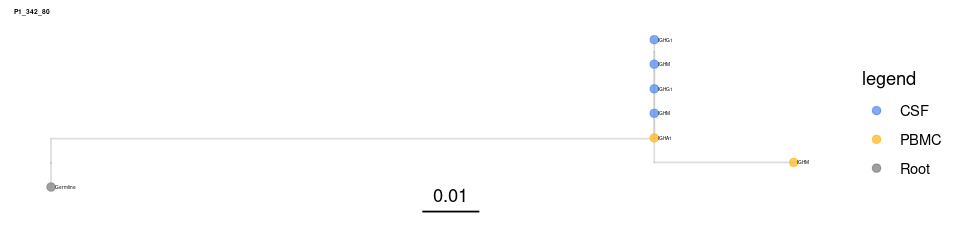

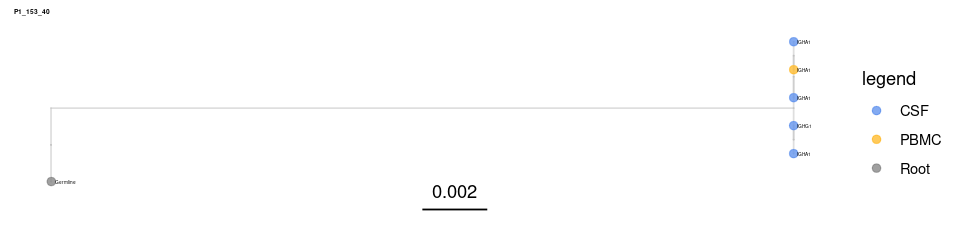

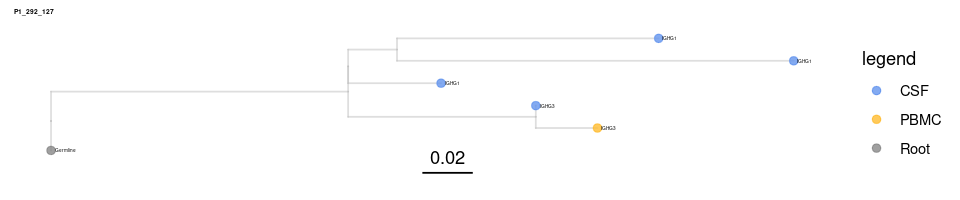

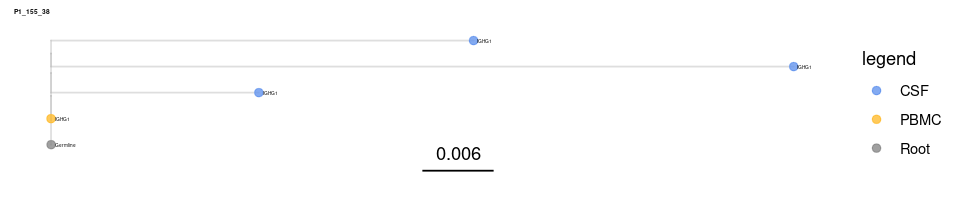

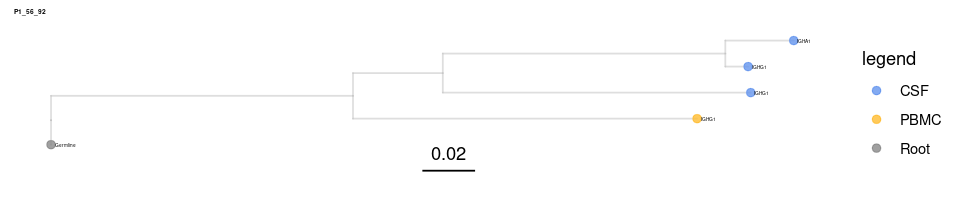

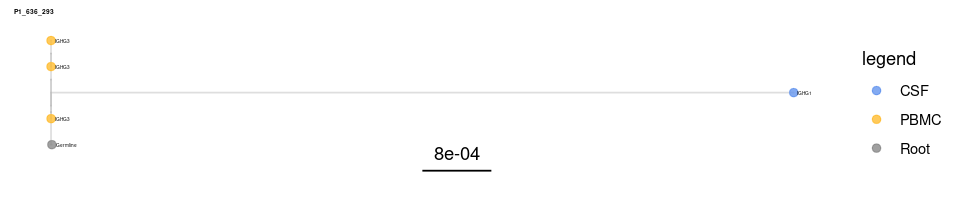

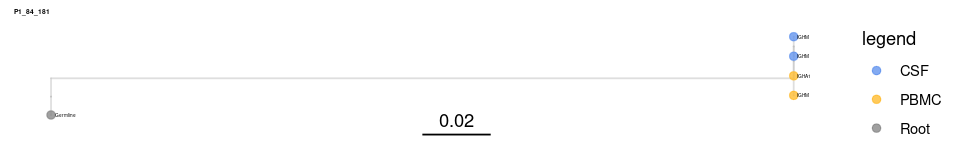

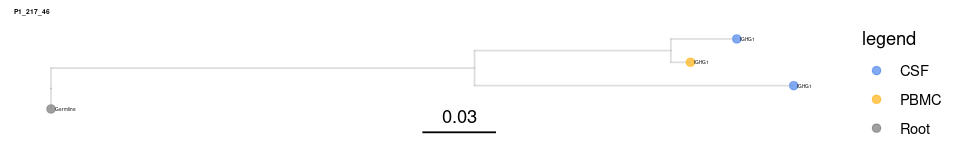

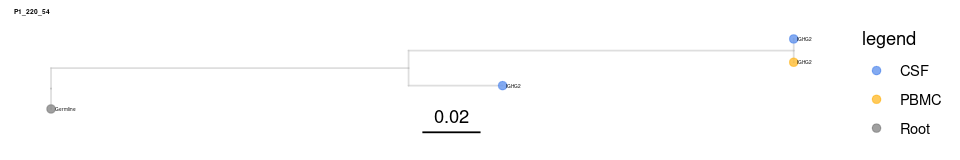

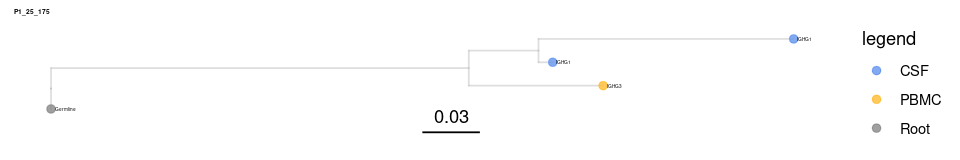

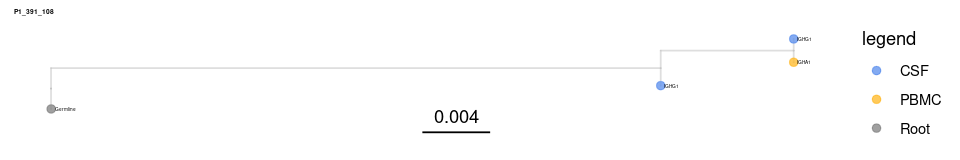

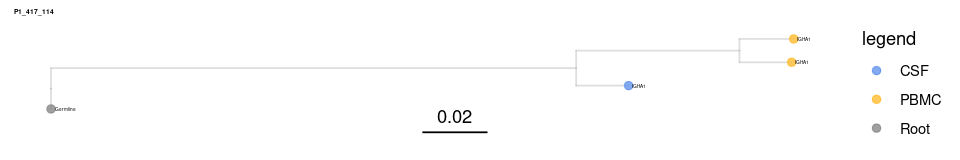

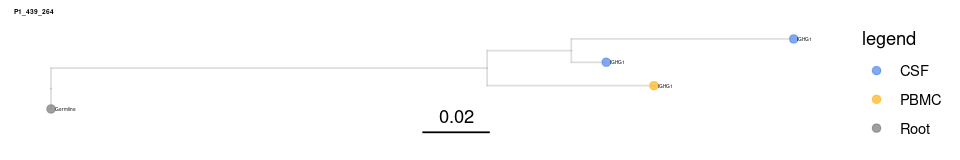

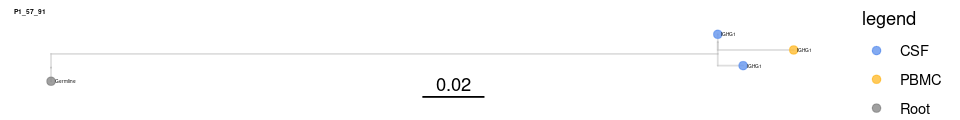

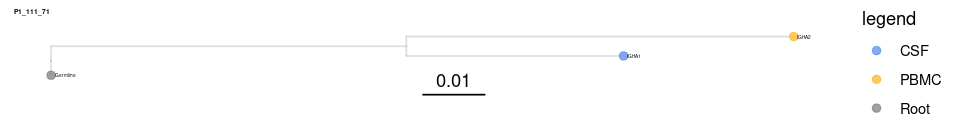

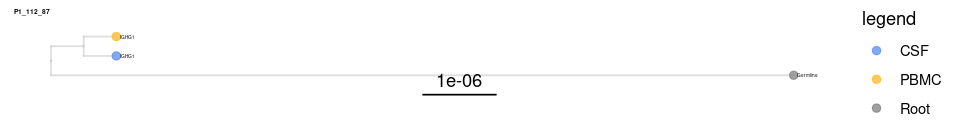

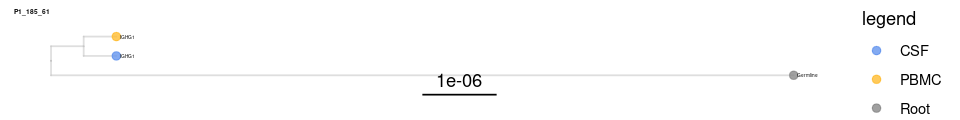

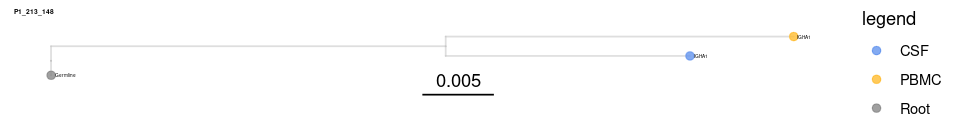

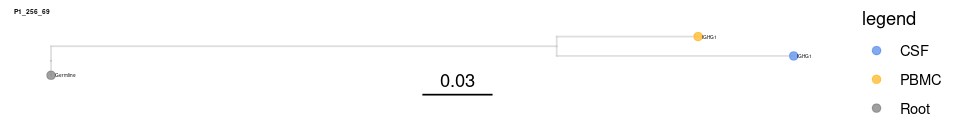

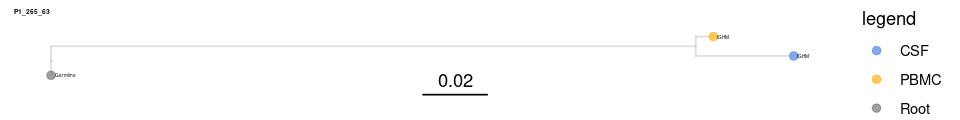

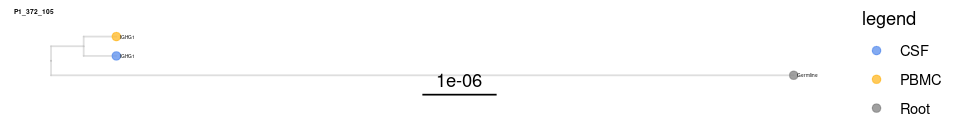

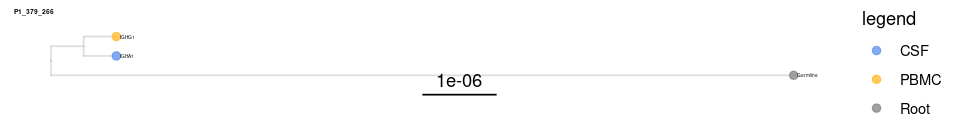

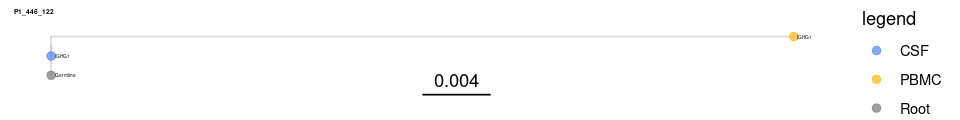

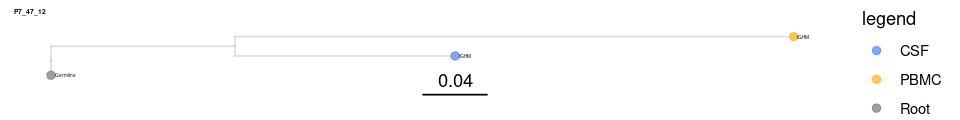

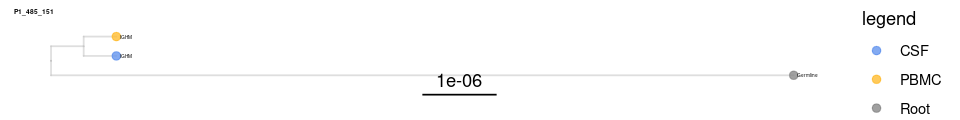

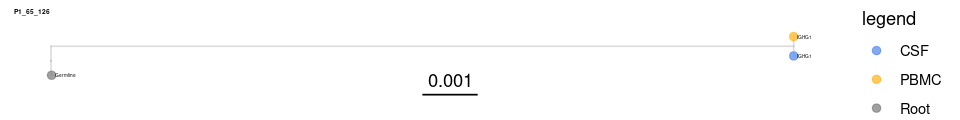

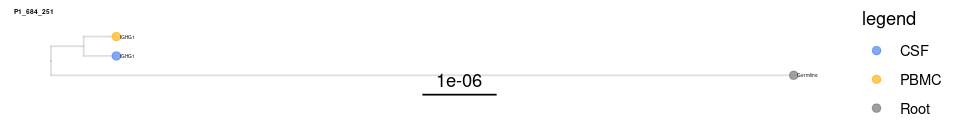

In [439]:
# the word taxa links meta data with tree

for(clone_toplot in names(trees)){
    g <- trees[[clone_toplot]]

    dd <- data.frame(SEQUENCE_ID = g$tip.label) %>%
        mutate(SEQUENCE_ID = as.character(SEQUENCE_ID)) %>%
        left_join(input %>% 
                  filter(CLONE == clone_toplot) %>%
                  mutate(legend = LOCATION, lab=C_CALL) %>%
                  select(SEQUENCE_ID, lab, legend), by = 'SEQUENCE_ID') %>%
        rename(taxa = SEQUENCE_ID) %>%
        mutate_if(is.factor, as.character) %>%
        replace_na(list(lab="Germline", legend="Root"))

    options(repr.plot.height=length(g$tip.label)/3, repr.plot.width=8)

    p <- ggtree(g, color="gray", alpha=0.5) %<+% dd +
        geom_tippoint(aes(color=legend), size=2, alpha=0.8) +
        geom_tiplab(aes(label=lab), color="black", size=1) + 
        #xlim(0, 0.15) +
        ggtitle(clone_toplot) +
        theme(plot.title = element_text(size = 4, face = "bold")) +
        geom_treescale() +
        scale_color_manual(values=LOCATION_COLORS)
    plot(p)

    plotFigure(p, file.path(BASE_DIR, "trees", paste0(clone_toplot,".pdf")), 
              width=8, height=length(g$tip.label)/3)
}

# COVID Specific 
- Compare CSF data with table of published antibodies from https://doi.org/10.1016/j.cell.2020.09.049

In [126]:
covid <- read.csv(file.path(BASE_DIR, 'Published_COVID19.csv'), sep = ',') %>%
    rowwise() %>%
    mutate(CDR3_AA_LENGTH = nchar(as.character(CDR3_AA_TARGET))) %>%
    ungroup() %>%
    mutate(V_CALL = paste0("IGHV", IGHV_TARGET),
           J_CALL = paste0("IGHJ", IGHJ_TARGET),
           CDR3_AA = CDR3_AA_TARGET,
           TYPE = "TARGET"
          ) %>%
    select(ID_TARGET, V_CALL, J_CALL, TYPE, CDR3_AA_LENGTH, CDR3_AA_TARGET)

In [127]:
covid

ID_TARGET    V_CALL     J_CALL TYPE   CDR3_AA_LENGTH
1   HL CV01-101  IGHV3-74   IGHJ3  TARGET 10            
2   HL CV01-102  IGHV3-21   IGHJ4  TARGET 17            
3   HK CV01-103  IGHV1-69   IGHJ4  TARGET 15            
4   HL CV01-104  IGHV1-18   IGHJ4  TARGET 17            
5   HK CV01-107  IGHV3-74   IGHJ6  TARGET 21            
6   HK CV01-109  IGHV3-7    IGHJ4  TARGET 11            
7   HK CV01-110  IGHV3-7    IGHJ4  TARGET 18            
8   HK CV01-111  IGHV3-15   IGHJ1  TARGET 11            
9   HL CV01-112  IGHV1-18   IGHJ4  TARGET 17            
10  HK CV01-113  IGHV3-15   IGHJ4  TARGET  7            
11  HL CV01-114  IGHV1-2    IGHJ4  TARGET 14            
12  HK CV01-116  IGHV3-7    IGHJ4  TARGET 11            
13  HL CV01-117  IGHV3-49   IGHJ4  TARGET 19            
14  HK CV01-118  IGHV3-9    IGHJ3  TARGET 16            
15  HK CV01-120  IGHV4-30-4 IGHJ3  TARGET 19            
16  HK CV01-121  IGHV4-38-2 IGHJ4  TARGET 13            
17  HK CV01-122  IGHV3-7    IGHJ4  TARGET 11            
18  HK CV01-123  IGHV3-7    IGHJ4  TARGET 10            
19  HK CV01-124  IGHV3-23   IGHJ4  TARGET 21            
20  HL CV01-125  IGHV1-18   IGHJ4  TARGET 17            
21  HL CV01-126  IGHV5-51   IGHJ6  TARGET 19            
22  HK CV01-128  IGHV3-7    IGHJ4  TARGET 11            
23  HL CV01-129  IGHV1-18   IGHJ4  TARGET 17            
24  HK CV01-130  IGHV3-7    IGHJ3  TARGET 16            
25  HK CV01-132  IGHV4-59   IGHJ6  TARGET 18            
26  HK CV01-133  IGHV3-7    IGHJ4  TARGET 11            
27  HK CV01-134  IGHV3-30   IGHJ6  TARGET 25            
28  HL CV01-135  IGHV3-11   IGHJ4  TARGET 12            
29  HK CV01-137  IGHV3-7    IGHJ4  TARGET 10            
30  HK CV01-138  IGHV4-39   IGHJ5  TARGET 20            
⋮   ⋮            ⋮          ⋮      ⋮      ⋮             
567 HL CV-X1-146 IGHV3-23   IGHJ4  TARGET 12            
568 HL CV-X1-150 IGHV5-51   IGHJ4  TARGET 15            
569 HL CV-X1-153 IGHV3-33   IGHJ4  TARGET 13            
570 HL CV-X1-157 IGHV3-48   IGHJ6  TARGET 19            
571 HK CV-X1-164 IGHV1-2    IGHJ6  TARGET 15            
572 HL CV-X1-165 IGHV3-48   IGHJ4  TARGET 11            
573 HK CV-X1-167 IGHV3-74   IGHJ5  TARGET 14            
574 HL CV-X1-171 IGHV4-34   IGHJ4  TARGET 11            
575 HK CV-X1-172 IGHV3-48   IGHJ6  TARGET 19            
576 HK CV-X1-173 IGHV3-30   IGHJ3  TARGET 21            
577 HL CV-X1-174 IGHV3-21   IGHJ6  TARGET 19            
578 HK CV-X1-175 IGHV1-69   IGHJ4  TARGET 11            
579 HL CV-X1-177 IGHV3-30   IGHJ4  TARGET 12            
580 HK CV-X1-178 IGHV3-49   IGHJ6  TARGET 20            
581 HK CV-X1-180 IGHV4-39   IGHJ5  TARGET 13            
582 HL CV-X1-183 IGHV3-30   IGHJ4  TARGET 12            
583 HL CV-X1-188 IGHV4-4    IGHJ5  TARGET  9            
584 HL CV-X1-189 IGHV3-23   IGHJ6  TARGET 20            
585 HL CV-X1-190 IGHV3-30   IGHJ4  TARGET 12            
586 HK CV-X1-191 IGHV4-31   IGHJ4  TARGET 14            
587 HK CV-X1-195 IGHV3-64   IGHJ4  TARGET 15            
588 HK CV-X2-103 IGHV3-15   IGHJ5  TARGET 12            
589 HL CV-X2-105 IGHV3-73   IGHJ6  TARGET 18            
590 HK CV-X2-106 IGHV1-69   IGHJ6  TARGET 18            
591 HK CV-X2-107 IGHV3-66   IGHJ4  TARGET 12            
592 HK CV-X2-108 IGHV3-66   IGHJ4  TARGET 12            
593 HK CV-X2-109 IGHV5-51   IGHJ3  TARGET 21            
594 HK CV-X2-117 IGHV3-66   IGHJ4  TARGET 12            
595 HK CV-X2-118 IGHV3-30   IGHJ4  TARGET 20            
596 HK CV-X2-123 IGHV4-4    IGHJ6  TARGET 24            
    CDR3_AA_TARGET           
1   ARGSSNLFDI               
2   ARSGGYSGYDYSHRIDY        
3   ASGWGMEYSSSSADY          
4   ARADETMVQGVIPNFDY        
5   ARGRDCGGSSCYGYPYYGMDV    
6   ARAGSVGVVDY              
7   VRDRGYCVGDVCYTVLDY       
8   TTWFYYDIRDH              
9   ARADDTMVQGVIPNFDY        
10  ASIYYDF                  
11  ARGDAVARTLNLDY           
12  ARAGNIGAVDY              
13  GLSYYYDNGGYYSVPPIDV      
14  AKNSPSCADAVCYFDV         
15  AREGVLITIFGVARDA

In [133]:
hits <- hc_df %>%
    mutate(CDR3_AA = translateDNA(JUNCTION, trim=TRUE),
           CDR3_AA_LENGTH = nchar(CDR3_AA),
           V_CALL = getGene(V_CALL),
           J_CALL = getGene(J_CALL), 
           SOURCE = 'CELL'
          ) %>%
    select(CELL, IDENTITY, V_CALL, J_CALL, CDR3_AA, CDR3_AA_LENGTH) %>%
    left_join(covid) %>% filter(!is.na(TYPE))

Joining, by = c("V_CALL", "J_CALL", "CDR3_AA_LENGTH")


In [134]:
hits

CELL               IDENTITY   V_CALL   J_CALL CDR3_AA                
1    GGACGTCTCTGCCAGG-1 PBMC11_BCR IGHV3-9  IGHJ6  AKDMGSTFGDYYYYGMDV     
2    GGACGTCTCTGCCAGG-1 PBMC11_BCR IGHV3-9  IGHJ6  AKDMGSTFGDYYYYGMDV     
3    GTGCTTCAGGGCTTGA-1 PBMC11_BCR IGHV5-51 IGHJ4  ARSSTGATIDY            
4    GTGCTTCAGGGCTTGA-1 PBMC11_BCR IGHV5-51 IGHJ4  ARSSTGATIDY            
5    GTTCTCGGTAGCGTAG-1 PBMC11_BCR IGHV4-59 IGHJ4  ARLVPEYSSSEIDY         
6    CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
7    CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
8    CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
9    CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
10   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
11   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
12   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
13   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
14   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
15   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
16   CTGATCCGTTCCGGCA-1 PBMC11_BCR IGHV3-7  IGHJ4  TRGGGSSGWFY            
17   GGACGTCCAAGCCGCT-1 CSF1_BCR   IGHV5-51 IGHJ4  ARTYSSGWYVPDY          
18   GGACGTCCAAGCCGCT-1 CSF1_BCR   IGHV5-51 IGHJ4  ARTYSSGWYVPDY          
19   GGACGTCCAAGCCGCT-1 CSF1_BCR   IGHV5-51 IGHJ4  ARTYSSGWYVPDY          
20   GCGACCAGTCTAACGT-1 PBMC5_BCR  IGHV5-51 IGHJ4  ARHPGYCTNGVCYCDY       
21   GTCGTAATCGACGGAA-1 PBMC9_BCR  IGHV5-51 IGHJ4  ARFRQQLGDRYFDY         
22   GTCGTAATCGACGGAA-1 PBMC9_BCR  IGHV5-51 IGHJ4  ARFRQQLGDRYFDY         
23   CAGCTAAGTTATCGGT-1 PBMC12_BCR IGHV3-23 IGHJ4  ANGLLWFGELSPIFVY       
24   CAGCTAAGTTATCGGT-1 PBMC12_BCR IGHV3-23 IGHJ4  ANGLLWFGELSPIFVY       
25   CAGCTAAGTTATCGGT-1 PBMC12_BCR IGHV3-23 IGHJ4  ANGLLWFGELSPIFVY       
26   CGATCGGGTCTCATCC-1 PBMC11_BCR IGHV1-46 IGHJ4  AGGYSSSWFFD            
27   GGAATAATCCAACCAA-1 PBMC11_BCR IGHV1-46 IGHJ4  ARGTAMVQFDY            
28   GATGAAAAGAAACGAG-1 PBMC12_BCR IGHV3-23 IGHJ6  AKGRTTRGYNYYMDV        
29   GTTCTCGAGCGGATCA-1 PBMC12_BCR IGHV3-23 IGHJ6  AKKFSSSPYTFNMDV        
30   GAGGTGATCAGTTTGG-1 PBMC12_BCR IGHV3-23 IGHJ6  ANIRISPGHYYYMDV        
⋮    ⋮                  ⋮          ⋮        ⋮      ⋮                      
4523 TATTACCGTGCAACTT-1 PBMC7_BCR  IGHV3-23 IGHJ6  AKDFGANYDFWSGYYQTPSLPDV
4524 TATTACCGTGCAACTT-1 PBMC7_BCR  IGHV3-23 IGHJ6  AKDFGANYDFWSGYYQTPSLPDV
4525 TATTACCGTGCAACTT-1 PBMC7_BCR  IGHV3-23 IGHJ6  AKDFGANYDFWSGYYQTPSLPDV
4526 TGAGCCGCAGTCGTGC-1 PBMC12_BCR IGHV3-23 IGHJ4  AKDYDFWSGYLYYFDY       
4527 TGAGCCGCAGTCGTGC-1 PBMC12_BCR IGHV3-23 IGHJ4  AKDYDFWSGYLYYFDY       
4528 TGAGCCGCAGTCGTGC-1 PBMC12_BCR IGHV3-23 IGHJ4  AKDYDFWSGYLYYFDY       
4529 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4530 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4531 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4532 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4533 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4534 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4535 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4536 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4537 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4538 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4539 AAAGTAGCATAACCTG-1 PBMC11_BCR IGHV3-7  IGHJ4  AREGQLLLFDY            
4540 AGATCTGGTTTAGCTG-1 CSF5_BCR   IGHV3-30 IGHJ4  ARGEDSGGCPAF           
4541 AGATCTGGTTTAGCTG-1 CSF5_BCR   IGHV3-30 IGHJ4  ARGEDSGGCPAF           
4542 AGATCTGGTTTAGCTG-1 CSF5_BCR   IGHV3-30 IGHJ4  ARGEDSGGCPAF           
4543 AGATCTGGTTTAGCTG-1 CSF5_BCR   IGHV3-30 IGHJ4  ARGEDSGGCPAF           
4544 AGATCTGGTTTAGCTG-1 CSF5_B

In [138]:
hits %>%
    rowwise() %>%
    mutate(ABS_DIST = as.numeric(adist(CDR3_AA,CDR3_AA_TARGET))) %>%
    mutate(NORM_DIST = ABS_DIST/CDR3_AA_LENGTH) %>% 
    arrange(NORM_DIST) %>% write.csv(file.path(BASE_DIR, 'Published_COVID19_hits.csv'))